# **ICSS Final Project**
## **Tracing global narratives in foreign news coverage:** Uzbekistan’s take on the world

Import libraries

In [37]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import community as community_louvain  # Import Louvain community detection
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrowPatch
import geopandas as gpd
from collections import defaultdict
from wordcloud import WordCloud # !pip install wordcloud

Load data

In [39]:
data = pd.read_csv('/Users/mellome/Desktop/ICSS-FP/datasets/labeled_kun.csv')

## Alliances

In [41]:
# Parse the countries column and count frequencies
alliance_counts = Counter()
for row in data['alliances']:
    # Extract individual country names
    alliance_list = row[1:-1].replace("'", "").split(', ')
    alliance_counts.update(alliance_list)

# Convert frequency counts to a DataFrame
freq_alliances_df = pd.DataFrame(alliance_counts.items(), columns=['Alliance', 'Frequency'])
freq_alliances_df = freq_alliances_df[freq_alliances_df['Alliance'].str.strip().astype(bool)]

In [42]:
freq_alliances_df

Alliance  Frequency
0  European Union       2031
2  United Nations       2580
3             SCO        160
4            NATO       1396
5              G7        155
6             G20        151
7           BRICS         35
8   African Union          6
9     Arab League          4

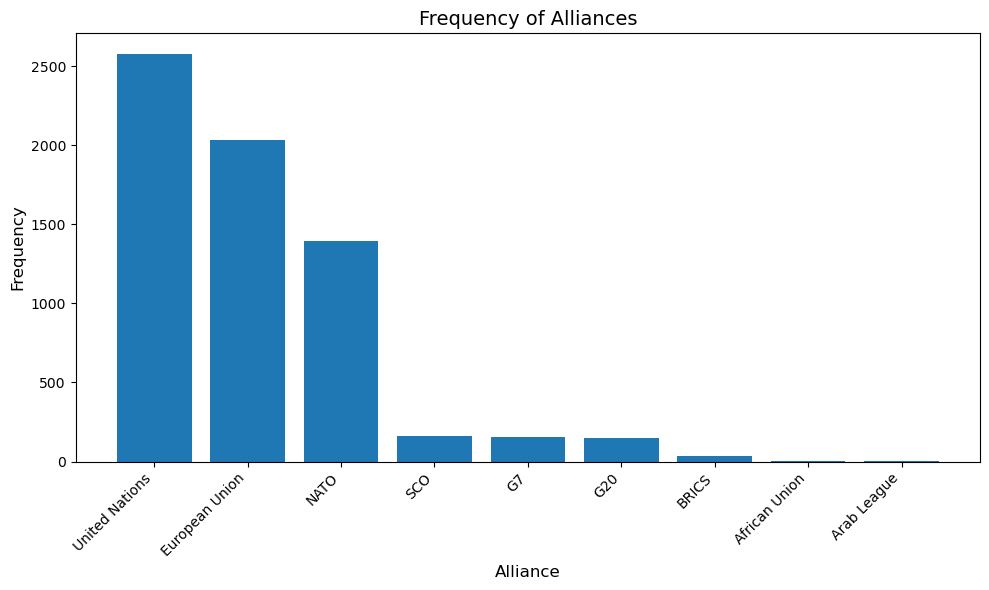

In [43]:
freq_alliances_df.sort_values(by=["Frequency"], ascending=False, inplace=True)
freq_alliances_df

plt.figure(figsize=(10, 6))
plt.bar(freq_alliances_df["Alliance"], freq_alliances_df["Frequency"])
plt.title("Frequency of Alliances", fontsize=14)
plt.xlabel("Alliance", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

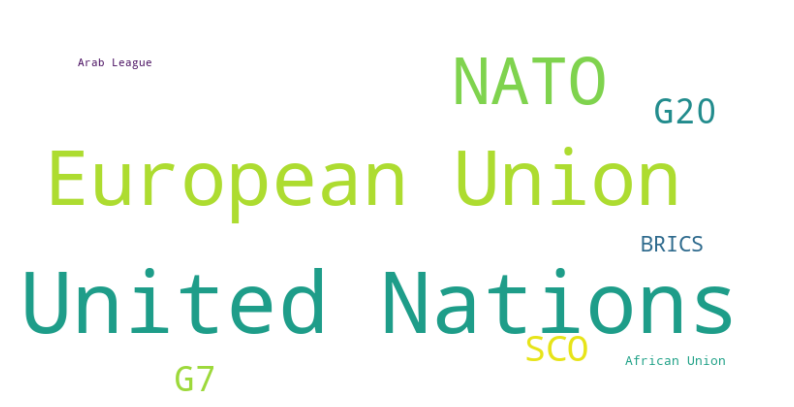

In [44]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      prefer_horizontal=1).generate_from_frequencies(
                                {"United Nations": 2580, "European Union": 2031, "NATO": 1396, "SCO": 160, 
                                    "G7": 155, "G20": 151, "BRICS": 35, "African Union": 6, "Arab League": 4}
                            )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.title("Alliance Frequency Word Cloud", fontsize=16)
plt.show()


## Countries

In [46]:
country_counts = Counter()
for row in data['countries']:
    # Extract individual country names
    country_list = row[1:-1].replace("'", "").split(', ')
    country_counts.update(country_list)

# Convert frequency counts to a DataFrame
freq_df = pd.DataFrame(country_counts.items(), columns=['Country', 'Frequency'])
world = gpd.read_file('/Users/mellome/Desktop/ICSS-FP/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
map = world
map = map.merge(freq_df, how='inner', left_on='NAME_LONG', right_on='Country')

<Axes: >

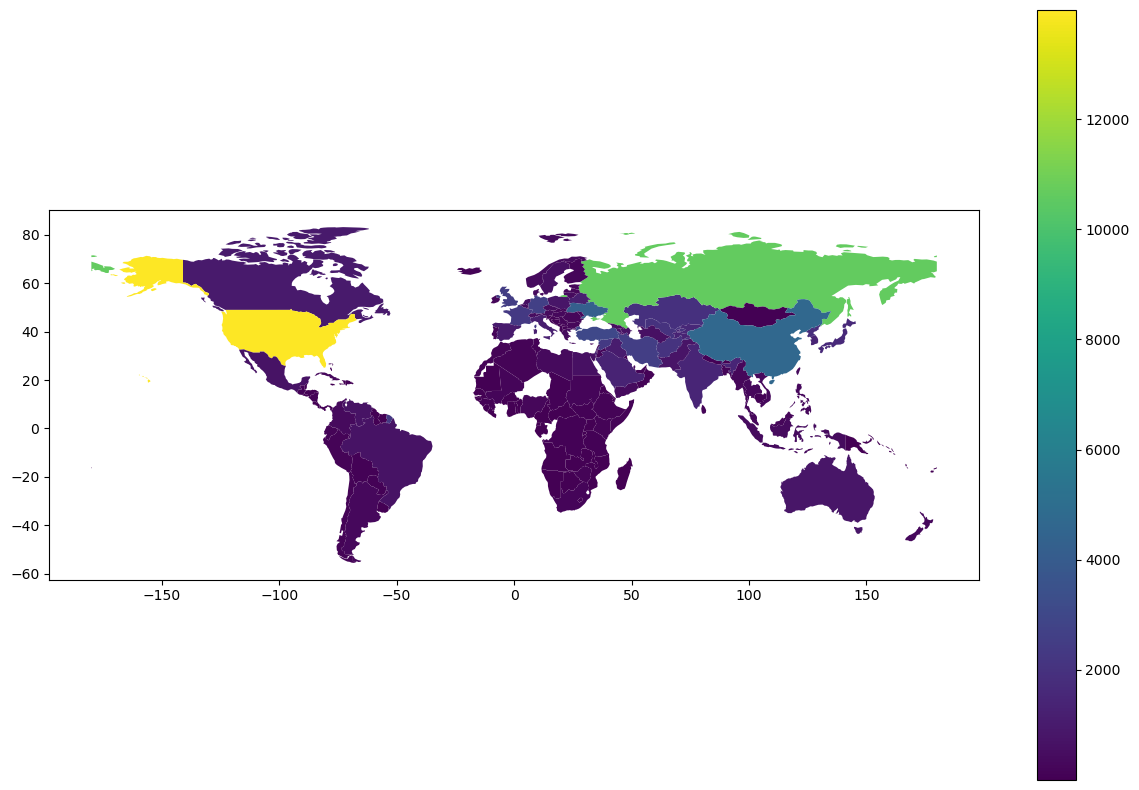

In [47]:
map.plot(column='Frequency', figsize=(15, 10), legend=True)

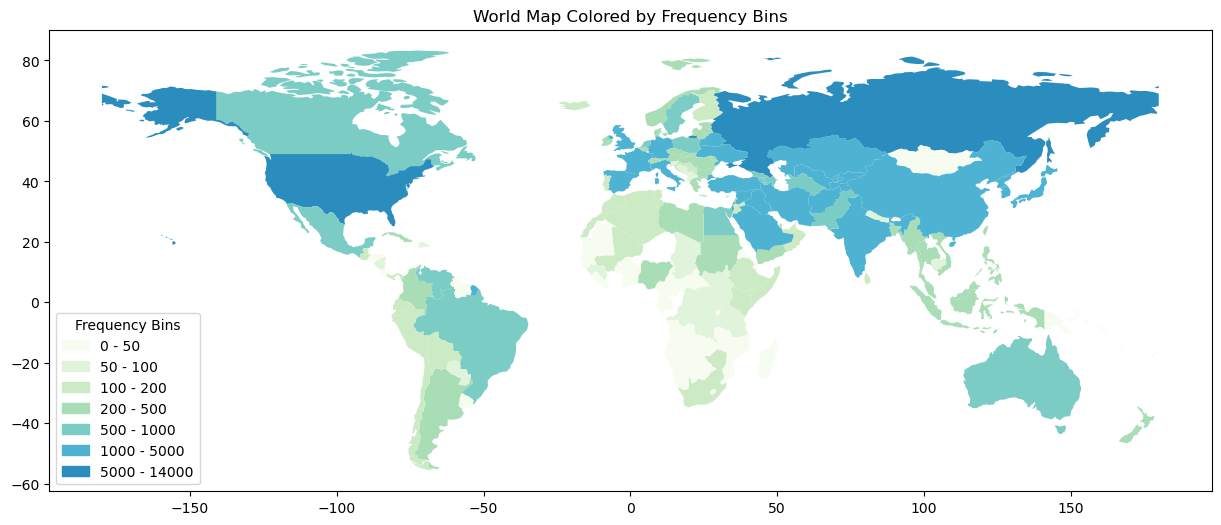

In [48]:
# # Merge frequency data with country boundaries
map['Frequency'] = map['Frequency'].fillna(0)  # Fill missing frequencies with 0

# Define custom bins and colors
custom_bins = [0, 50, 100, 200, 500, 1000, 5000, 14000]  # 8 edges, 7 bins
custom_colors = ['#f7fcf0', '#e0f3db', '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe']  # 7 colors

# Create a new column in `world` to categorize frequencies into bins
map['freq_bins'] = pd.cut(map['Frequency'], bins=custom_bins, labels=custom_colors, include_lowest=True)

# Map the bin labels (colors) to the GeoDataFrame
map['color'] = map['freq_bins']

# Plot the GeoDataFrame using the colors
map.plot(color=map['color'], figsize=(15, 10))
plt.title('World Map Colored by Frequency Bins')
legend_patches = [mpatches.Patch(color=color, label=f'{custom_bins[i]} - {custom_bins[i+1]}') 
                  for i, color in enumerate(custom_colors)]
plt.legend(handles=legend_patches, title='Frequency Bins', loc='lower left')

plt.show()

In [49]:
map = world
map = map.merge(freq_df, how='outer', left_on='NAME_LONG', right_on='Country')

# Merge frequency data with country boundaries
map['Frequency'] = map['Frequency'].fillna(0)  # Fill missing frequencies with 0

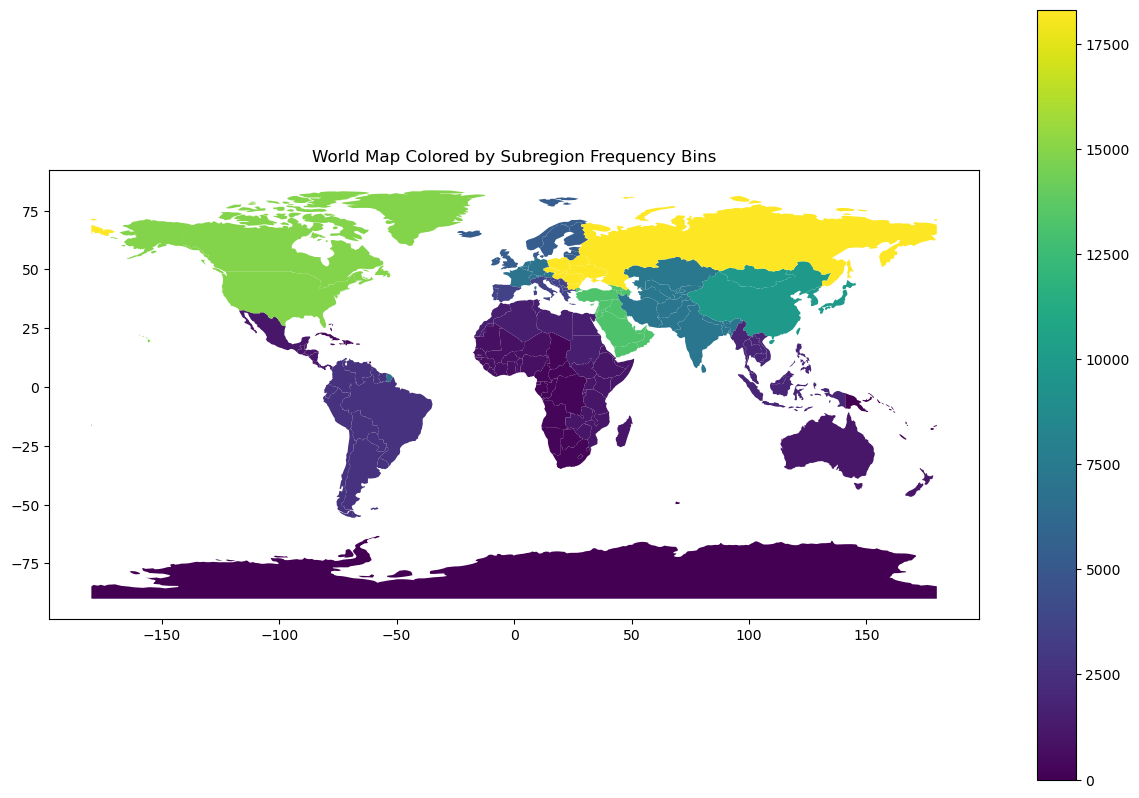

In [50]:
subregion_counts = map.groupby('SUBREGION')['Frequency'].sum().reset_index()

# Merge aggregated frequencies with map data
map = map.merge(subregion_counts, on='SUBREGION', how='left', suffixes=('', '_subregion'))

# Fill missing frequencies with 0
map['Frequency_subregion'] = map['Frequency_subregion'].fillna(0)

# Plot the GeoDataFrame using default color mapping
map.plot(column='Frequency_subregion', figsize=(15, 10), legend=True)
plt.title('World Map Colored by Subregion Frequency Bins')
plt.show()

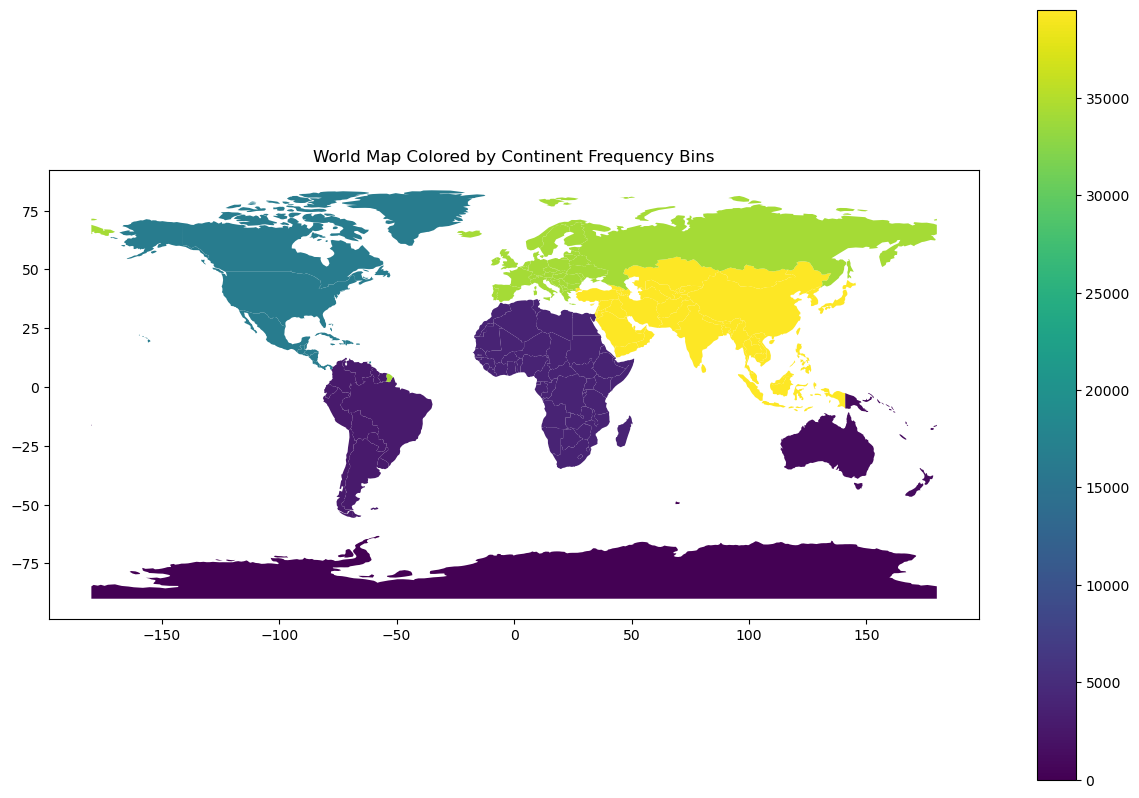

In [51]:
continent_counts = map.groupby('CONTINENT')['Frequency'].sum().reset_index()

# Merge aggregated frequencies with map data
map = map.merge(continent_counts, on='CONTINENT', how='left', suffixes=('', '_continent'))

# Fill missing frequencies with 0
map['Frequency_continent'] = map['Frequency_continent'].fillna(0)

# Plot the GeoDataFrame using default color mapping
map.plot(column='Frequency_continent', figsize=(15, 10), legend=True)
plt.title('World Map Colored by Continent Frequency Bins')
plt.show()

<Figure size 1200x800 with 0 Axes>

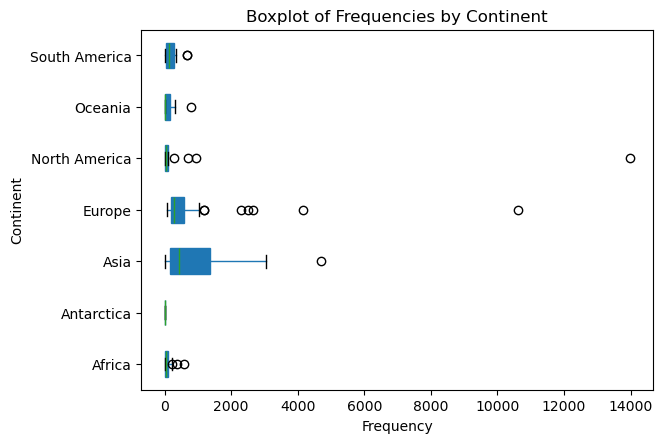

In [52]:
plt.figure(figsize=(12, 8))
map[map["CONTINENT"]!="Seven seas (open ocean)"].boxplot(column="Frequency", by="CONTINENT", grid=False, patch_artist=True, vert=False)
plt.title("Boxplot of Frequencies by Continent")
plt.suptitle("")  # Remove default Pandas subtitle
plt.xlabel("Frequency")
plt.ylabel("Continent")
plt.show()

<Figure size 1200x800 with 0 Axes>

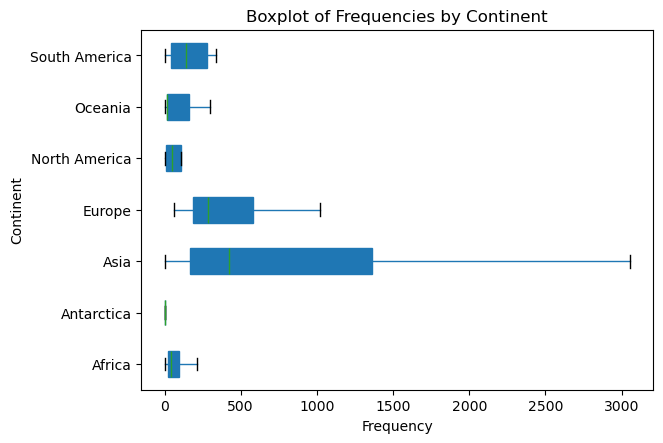

In [53]:
plt.figure(figsize=(12, 8))
map[map["CONTINENT"]!="Seven seas (open ocean)"].boxplot(column="Frequency", by="CONTINENT", grid=False, patch_artist=True, vert=False, showfliers=False)
plt.title("Boxplot of Frequencies by Continent")
plt.suptitle("")  # Remove default Pandas subtitle
plt.xlabel("Frequency")
plt.ylabel("Continent")
plt.show()

## Network

Create undirected graph

In [56]:
# Parse the countries column into pairs (edges)
edges = []
for countries in data['countries']:
    country_list = countries[1:-1].split(', ')  # Remove square brackets and split
    edges.extend([(str(country_list[i])[1:-1], str(country_list[j])[1:-1]) for i in range(len(country_list)) for j in range(i + 1, len(country_list))])

# Count edge occurrences to set weights
edge_counts = Counter(edges)

# Create the graph and add weighted edges based on co-occurrence count
G = nx.Graph()
for (country1, country2), weight in edge_counts.items():
    G.add_edge(country1, country2, weight=weight)

# Calculate degree centrality to scale node sizes
degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality and select the top 50
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)

In [57]:
node_degrees = G.degree(weight='weight')

# Convert the degree information into a DataFrame
degree_df = pd.DataFrame(node_degrees, columns=['Node', 'Degree'])
combined_df = pd.merge(degree_df, freq_df, left_on='Node', right_on='Country', how='inner')
combined_df = combined_df.drop(columns=['Country'])


unique_connections = {node: len(set(G.neighbors(node))) for node in G.nodes}
connections_df = pd.DataFrame(unique_connections.items(), columns=['Node', 'UniqueConnections'])
combined_df = pd.merge(combined_df, connections_df, on='Node', how='inner')

# Calculate the total rows in the data for frequency proportion calculation
total_rows = data.shape[0]

# Add a column to calculate the proportion of each node's frequency to the total rows
combined_df['FrequencyProportion'] = combined_df['Frequency'] / total_rows
total_possible_connections = len(G.nodes) - 1  # Total nodes minus the node itself
combined_df['UniqueConnectionProportion'] = combined_df['UniqueConnections'] / total_possible_connections

combined_df.to_csv('datasets/node.csv')


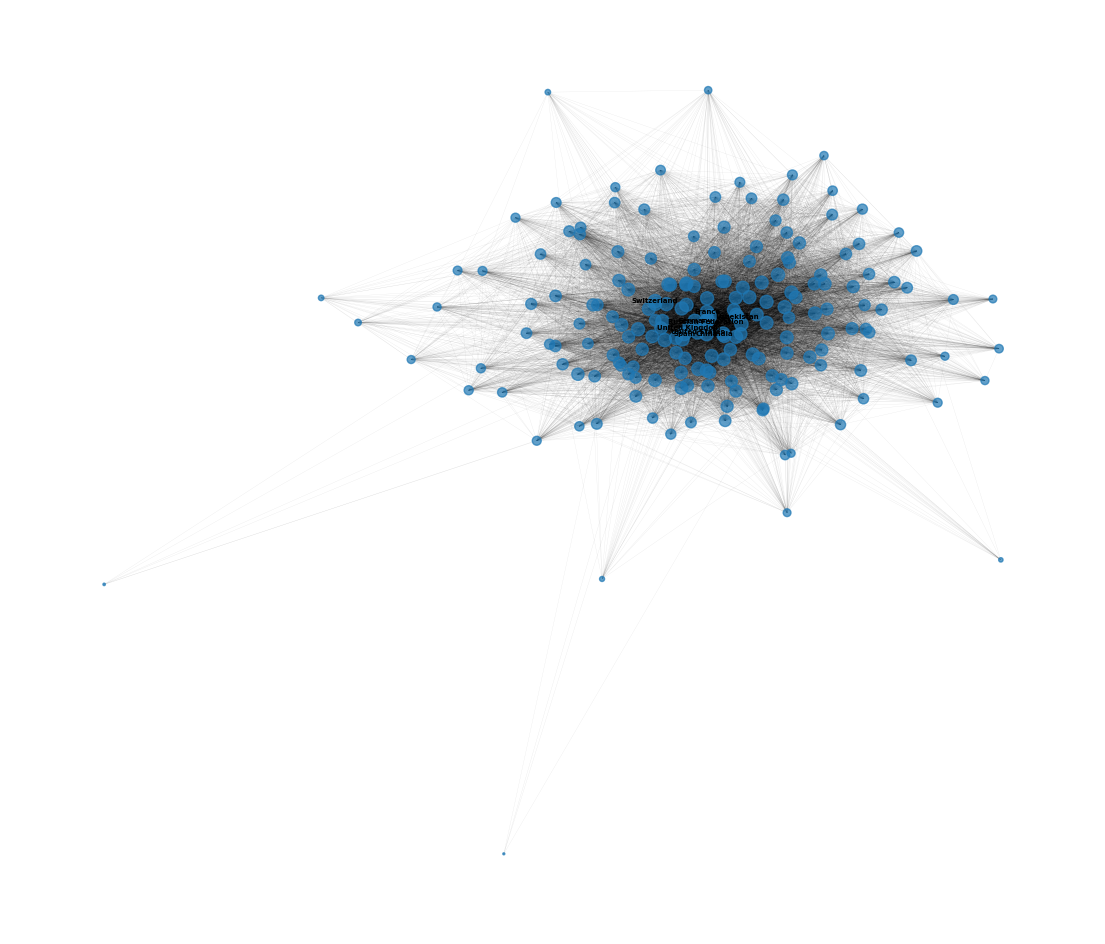

In [58]:
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G) #, seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.2)


# Ensure we're only labeling nodes that exist in G
top_central_nodes = [node for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10] if node in G]
nx.draw_networkx_labels(
    G, pos,
    labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold'
)


# plt.title("Network Visualization")
plt.axis("off")
plt.show()


Filter and consider only countries with over 100 mentions

In [60]:
# Filter edges with weight > 100
filtered_edges = [(country1, country2, weight) for (country1, country2), weight in edge_counts.items() if weight > 100] # if weight > 100

# Create the graph and add filtered edges
G = nx.Graph()
G.add_weighted_edges_from(filtered_edges)

# Calculate degree centrality to scale node sizes
degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality and select the top 50
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
G = G.subgraph(top_nodes)  # Subgraph with only the top 50 nodes


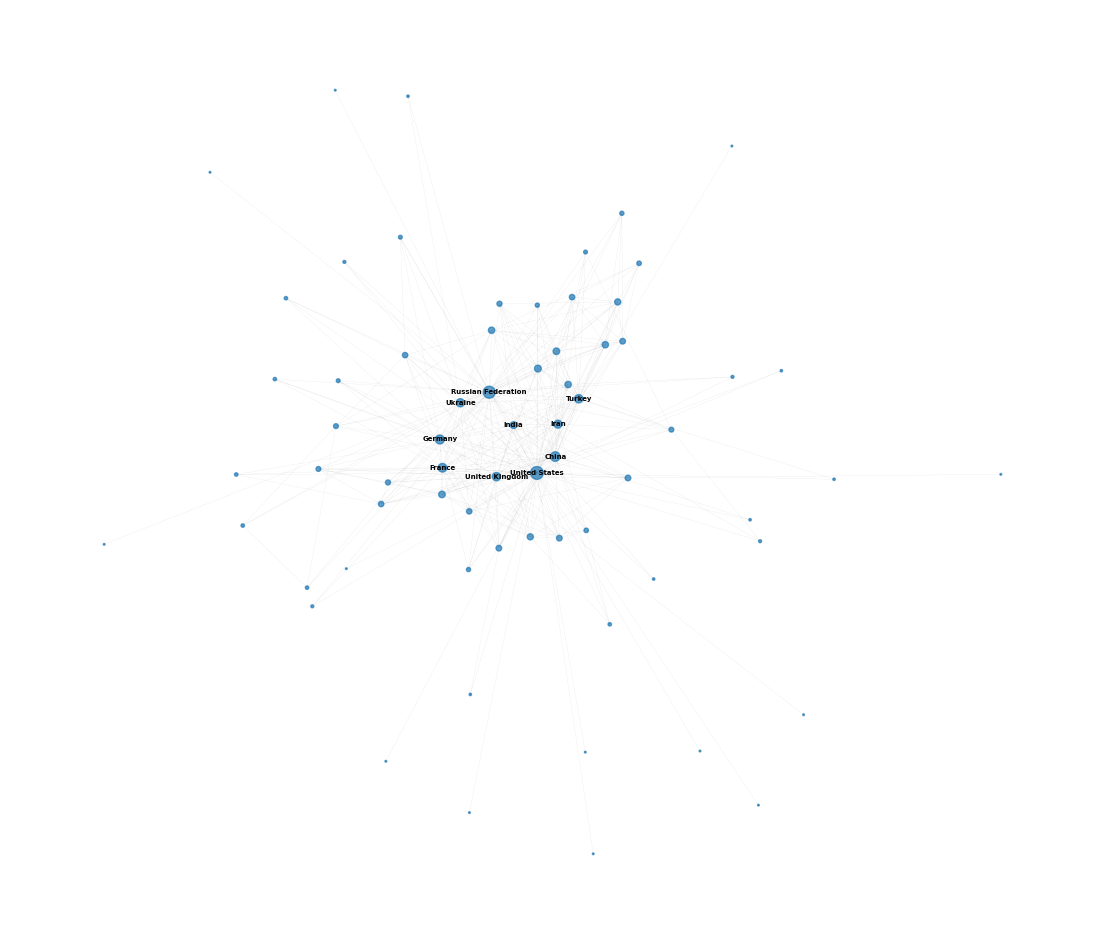

In [61]:
# Prepare plot
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)  # , seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.2)

# Ensure we're only labeling nodes that exist in G
top_central_nodes = [node for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10] if node in G]
nx.draw_networkx_labels(
    G, pos,
    labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold'
)

# plt.title("Advanced Network Visualization of Top 50 Country Network with Community Detection and Centrality")
plt.axis("off")
plt.show()


In [62]:
# Function to draw a curved edge
def draw_curved_edge(ax, pos, src, dest, color, weight, curvature=0.2):
    src_pos = pos[src]
    dest_pos = pos[dest]
    # Create a FancyArrowPatch for curved edges
    arrow = FancyArrowPatch(
        src_pos,
        dest_pos,
        connectionstyle=f"arc3,rad={curvature}",  # 'rad' controls curvature
        color=color,
        lw=weight * 0.001,  # Scale the width for visualization
        alpha=0.5,
        arrowstyle="-",  # Just a line, no arrowhead
    )
    ax.add_patch(arrow)

def get_color(node):
    if node in partition and partition[node] < len(community_color_map):
        return community_color_map[partition[node]]
    return 'white'


# Function to get edge color and node size based on weight
def get_node_size_and_edge_color(weight):
    for min_w, max_w, size, color in weight_ranges:
        if min_w <= weight <= max_w:
            return size, color
    return 5, '#D3D3D3'  # Default size and light grey color


/var/folders/vb/thqcpq9125j2b5v_172vv4k00000gn/T/ipykernel_34443/263095090.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world["centroid"] = world.geometry.centroid


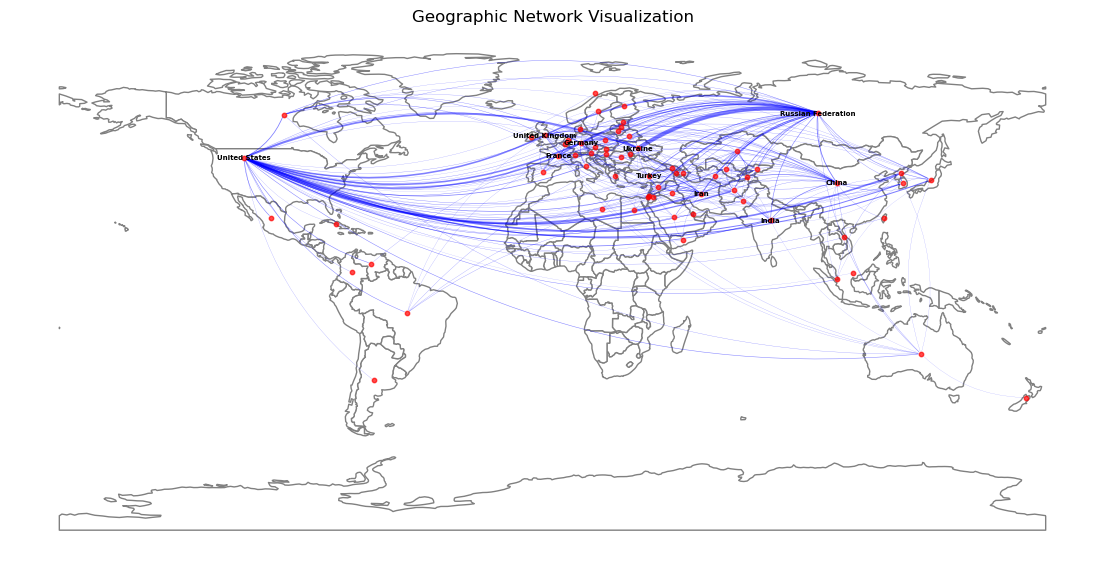

In [63]:
# Adjust the weight ranges for both edges and node sizes
weight_ranges = [
    (0, 100, 5, '#D3D3D3'),  # Light grey
    (101, 200, 10, '#D3D3D3'),  # Light grey
    (201, 300, 20, '#A9A9A9'),  # Dark grey
    (301, 400, 30, '#696969'),  # Dim grey
    (401, 500, 40, '#505050'),  # Medium grey
    (501, float('inf'), 50, '#000000')  # Black
]

# Background map
world = gpd.read_file('/Users/mellome/Desktop/ICSS-FP/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
ax = world.plot(color='white', edgecolor='grey', figsize=(14, 12))
# ax = world.plot(column='SUBREGION', cmap='tab20', figsize=(14, 12))
# ax = world.plot(column='REGION_UN', cmap='tab20', figsize=(14, 12))
# ax = world.plot(column='REGION_WB', cmap='tab20', figsize=(14, 12))
# ax = world.plot(column='CONTINENT', cmap='tab20', figsize=(14, 12))

# Prepare data for node sizes and edge colors

world["centroid"] = world.geometry.centroid
geo_pos = {
    row["NAME_LONG"]: (row["centroid"].x, row["centroid"].y)
    for _, row in world.iterrows()
}
# Correct geographic coordinates for France
if "France" in geo_pos:
    geo_pos["France"] = (2.0844, 46.3964)
if "Singapore" not in geo_pos:
    geo_pos["Singapore"] = (103.8198, 1.3521)  # Approximate coordinates for Singapore

node_sizes = {}
edge_colors = {}
for node in G.nodes:
    total_weight = sum(edge_data['weight'] for _, _, edge_data in G.edges(node, data=True))
    node_sizes[node], _ = get_node_size_and_edge_color(total_weight)

for edge in G.edges(data=True):
    weight = edge[2].get('weight', 1)  # Default weight is 1 if missing
    _, edge_color = get_node_size_and_edge_color(weight)
    edge_colors[(edge[0], edge[1])] = edge_color

# Draw curved edges
for edge, color in edge_colors.items():
    src, dest = edge
    weight = G.edges[edge].get('weight', 1)
    draw_curved_edge(ax, geo_pos, src, dest, color="blue", weight=weight, curvature=0.2)  # Adjust curvature as needed

# Draw nodes
nx.draw_networkx_nodes(
    G, geo_pos,
    node_size=10,
    node_color="red",
    alpha=0.7,
    ax=ax
)

# Draw labels for top nodes
nx.draw_networkx_labels(
    G, geo_pos,
    labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold',
    ax=ax
)

# Finalize plot
plt.title("Geographic Network Visualization")
plt.axis("off")
plt.show()

Perform Louvain community detection

In [65]:
partition = community_louvain.best_partition(G, weight='weight')

# Map community numbers to colors
community_colors = [partition[node] for node in G.nodes]
unique_communities = set(community_colors)
community_color_map = {comm: plt.cm.tab20(i / len(unique_communities)) for i, comm in enumerate(unique_communities)}

# Experiment with different values of resolution
resolution = 2.5# Adjust this value as needed
partition = community_louvain.best_partition(G, weight='weight', resolution=resolution)

# Count the number of communities detected
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

# Map community numbers to colors
community_colors = [partition[node] for node in G.nodes]
unique_communities = set(community_colors)
community_color_map = {comm: plt.cm.tab20(i / len(unique_communities)) for i, comm in enumerate(unique_communities)}

Number of communities detected: 13


In [66]:
# Group nodes by community
community_nodes = defaultdict(list)
for node, community in partition.items():
    community_nodes[community].append(node)

# Find the top node in each community based on degree centrality
top_nodes_per_community = {}
for community, nodes in community_nodes.items():
    # Get the node with the highest degree centrality in this community
    top_node = max(nodes, key=lambda node: degree_centrality[node])
    top_nodes_per_community[community] = top_node
    print(f"Top node in community {community}: {top_node}")


Top node in community 0: Lithuania
Top node in community 1: Russian Federation
Top node in community 7: Germany
Top node in community 3: Uzbekistan
Top node in community 4: United States
Top node in community 5: China
Top node in community 6: Japan
Top node in community 8: Turkey
Top node in community 11: Afghanistan
Top node in community 12: France
Top node in community 9: United Kingdom
Top node in community 2: Israel
Top node in community 10: Australia


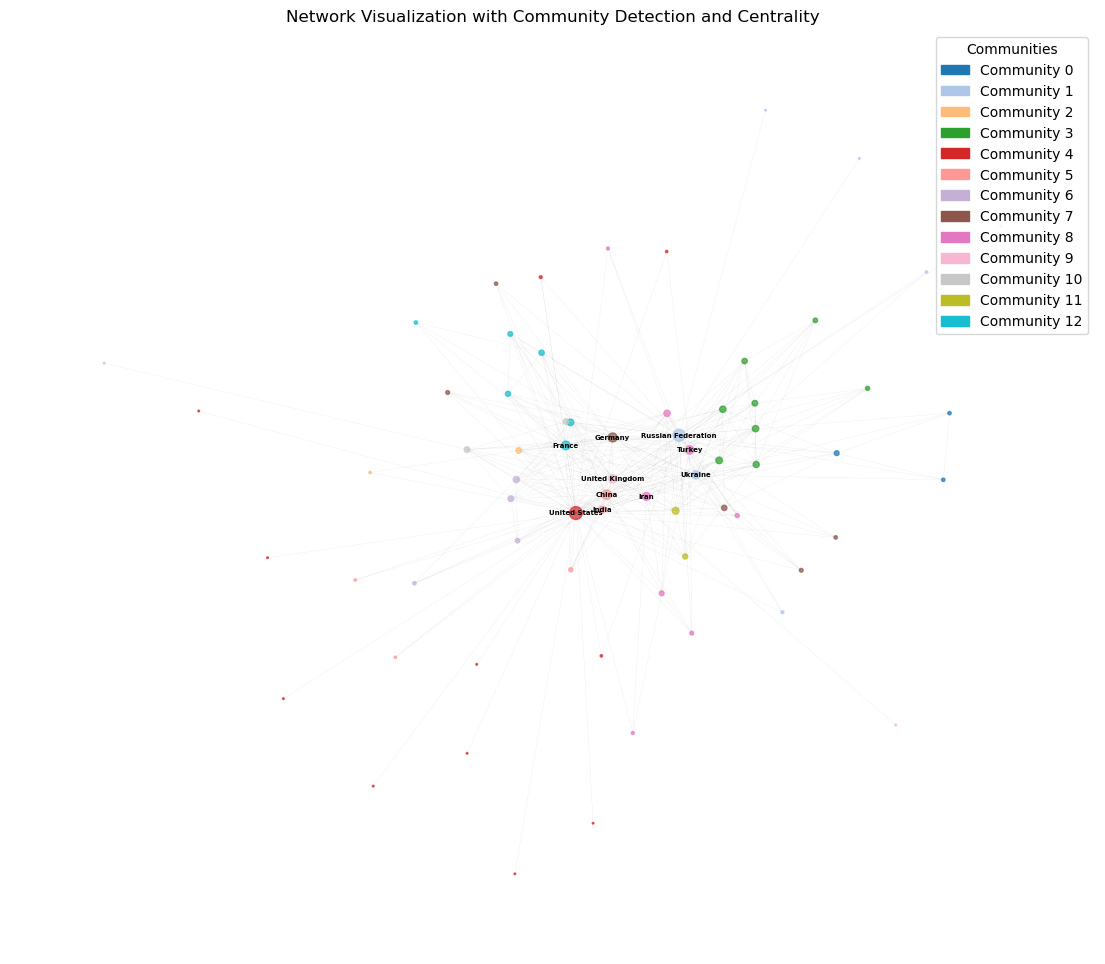

In [67]:
# Prepare plot
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)  # , seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=[community_color_map[partition[node]] for node in G.nodes],
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.2)

# Ensure we're only labeling nodes that exist in G
top_central_nodes = [node for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10] if node in G]
nx.draw_networkx_labels(
    G, pos,
    labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold'
)

# Add a legend for communities
community_patches = [
    mpatches.Patch(color=community_color_map[comm], label=f'Community {comm}')
    for comm in unique_communities
]
plt.legend(handles=community_patches, title="Communities", loc='upper right')

plt.title("Network Visualization with Community Detection and Centrality")
plt.axis("off")
plt.show()


/var/folders/vb/thqcpq9125j2b5v_172vv4k00000gn/T/ipykernel_34443/1584099640.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world["centroid"] = world.geometry.centroid


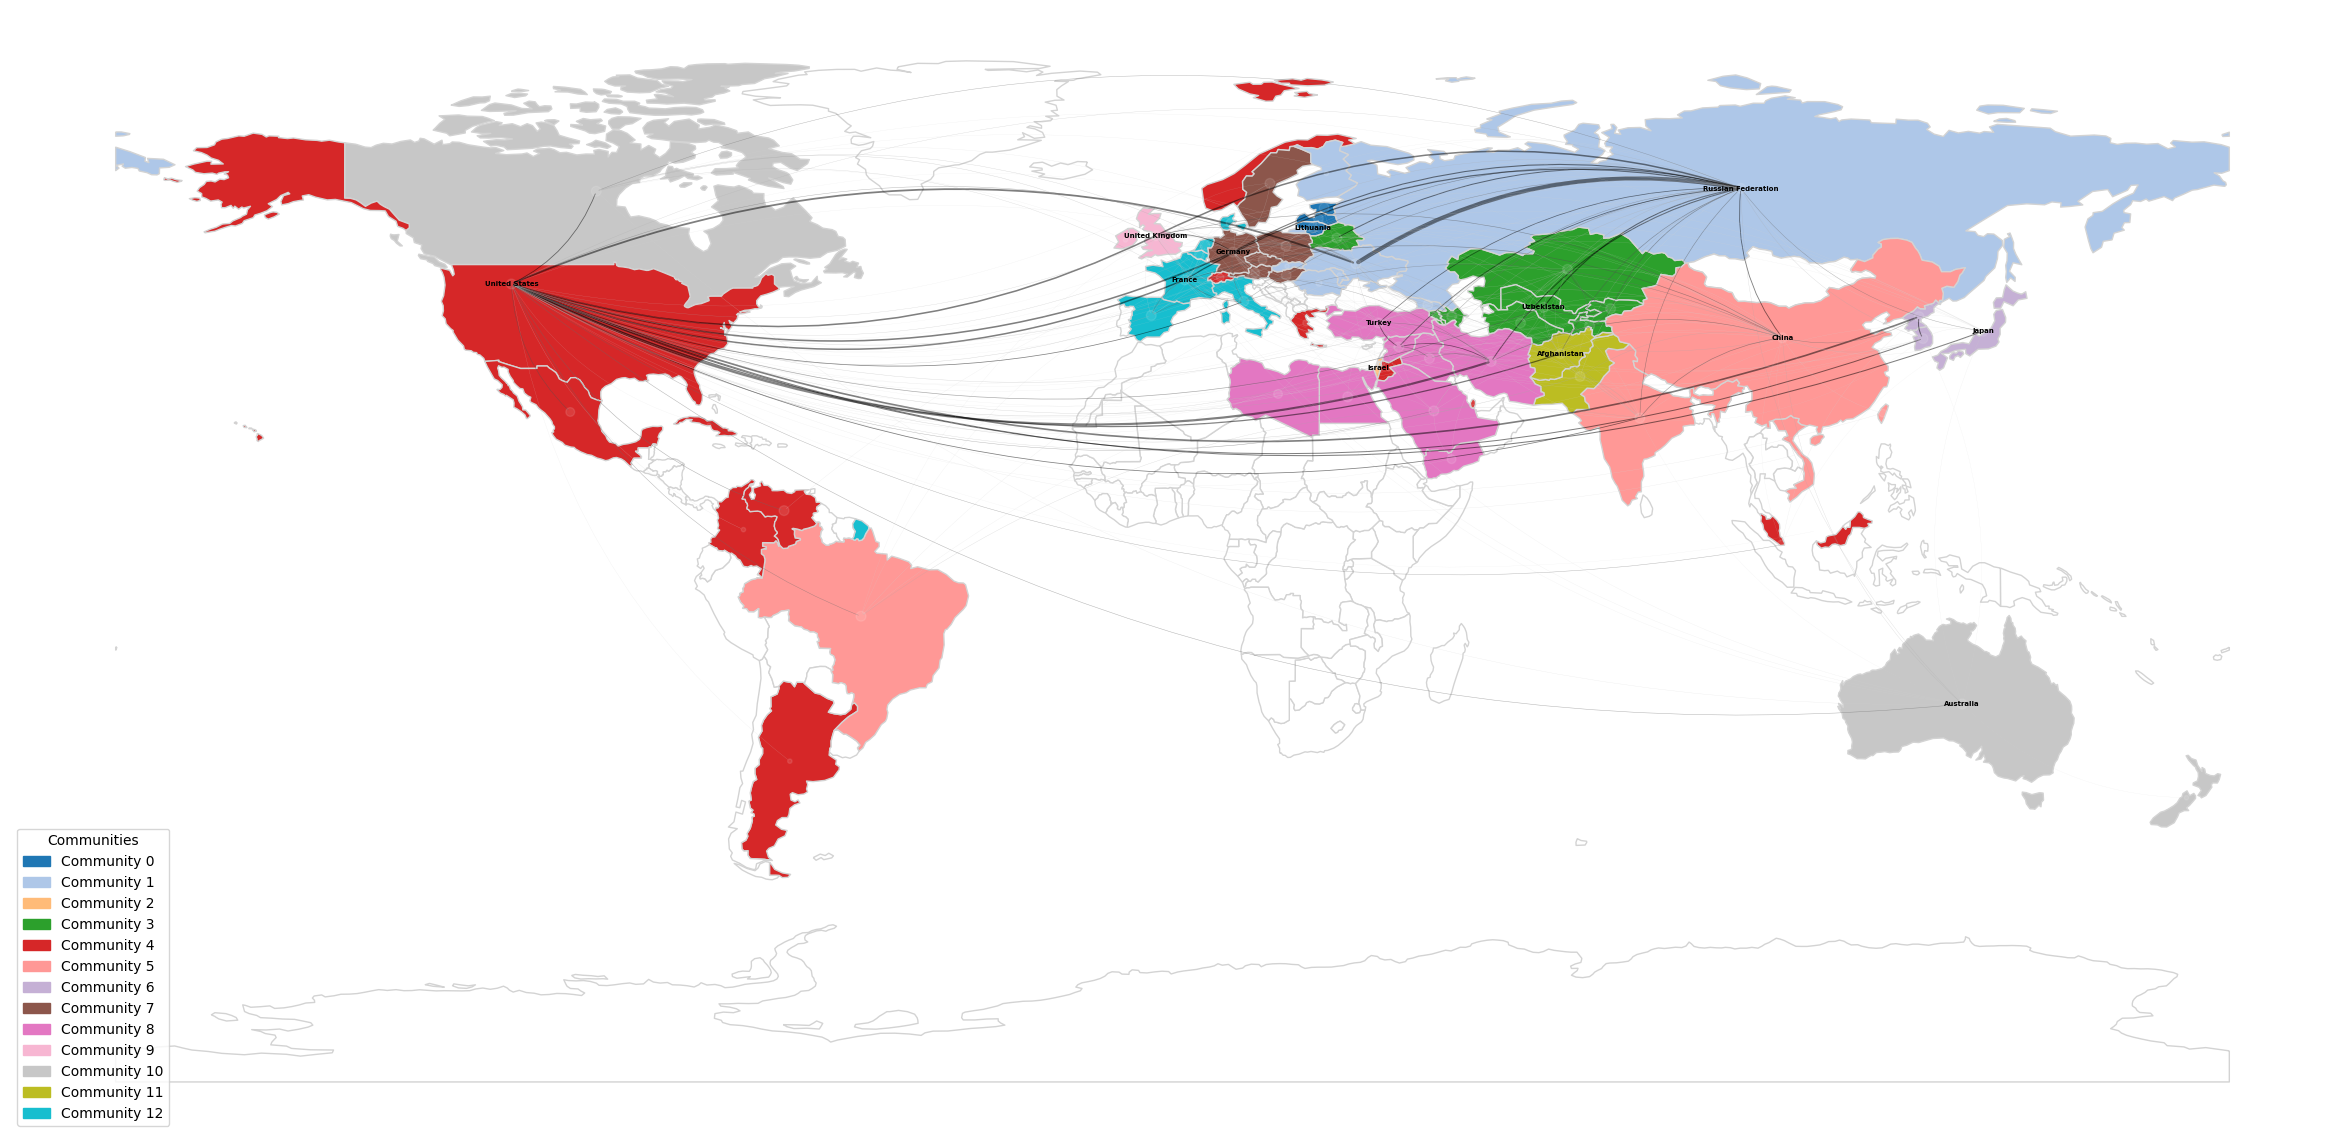

In [68]:
# Adjust the weight ranges for both edges and node sizes
weight_ranges = [
    (0, 100, 5, '#D3D3D3'),  # Light grey
    (101, 200, 10, '#D3D3D3'),  # Light grey
    (201, 300, 20, '#A9A9A9'),  # Dark grey
    (301, 400, 30, '#696969'),  # Dim grey
    (401, 500, 40, '#505050'),  # Medium grey
    (501, float('inf'), 50, '#000000')  # Black
]

# Background map
world = gpd.read_file('/Users/mellome/Desktop/ICSS-FP/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
# ax = world.plot(color='white', edgecolor='grey', figsize=(14, 12))
world['color'] = world['NAME_LONG'].apply(lambda x: get_color(x))
ax = world.plot(color=world['color'], edgecolor='lightgrey', figsize=(30, 20))

world["centroid"] = world.geometry.centroid
geo_pos = {
    row["NAME_LONG"]: (row["centroid"].x, row["centroid"].y)
    for _, row in world.iterrows()
}
# Correct geographic coordinates for France
if "France" in geo_pos:
    geo_pos["France"] = (2.0844, 46.3964)
if "Singapore" not in geo_pos:
    geo_pos["Singapore"] = (103.8198, 1.3521)  # Approximate coordinates for Singapore

# Prepare data for node sizes and edge colors
node_sizes = {}
edge_colors = {}
for node in G.nodes:
    total_weight = sum(edge_data['weight'] for _, _, edge_data in G.edges(node, data=True))
    node_sizes[node], _ = get_node_size_and_edge_color(total_weight)

for edge in G.edges(data=True):
    weight = edge[2].get('weight', 1)  # Default weight is 1 if missing
    _, edge_color = get_node_size_and_edge_color(weight)
    edge_colors[(edge[0], edge[1])] = edge_color

# Draw curved edges
for edge, color in edge_colors.items():
    src, dest = edge
    weight = G.edges[edge].get('weight', 1)
    draw_curved_edge(ax, geo_pos, src, dest, color=color, weight=weight, curvature=0.2)  # Adjust curvature as needed

# Draw nodes
nx.draw_networkx_nodes(
    G, geo_pos,
    node_size=[node_sizes[node] for node in G.nodes],
    node_color="white", #[community_color_map[partition[node]] for node in G.nodes]
    alpha=0.1,
    ax=ax
)

# Draw labels for top nodes
nx.draw_networkx_labels(
    G, geo_pos,
    labels={node: node for community, node in top_nodes_per_community.items()},
    # labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold',
    ax=ax
)

# Add a legend for communities
unique_communities = set(partition.values())
community_patches = [
    mpatches.Patch(color=community_color_map[comm], label=f'Community {comm}')
    for comm in unique_communities
]
plt.legend(handles=community_patches, title="Communities", loc='lower left')

# Finalize plot
# plt.title("Geographic Network Visualization with Curved Edges")
plt.axis("off")
plt.show()

## Big 3

In [70]:
density = nx.density(G)
print("Network Density:", density)

Network Density: 0.14266900790166814


In [71]:
if nx.is_connected(G):
    avg_path_length = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
    print("Average Path Length:", avg_path_length)
    print("Network Diameter:", diameter)

Average Path Length: 1.9525899912203688
Network Diameter: 3


In [72]:
# ego = nx.ego_graph(G, "Russian Federation", radius=1)
# nx.draw_networkx(ego, with_labels=True)
# plt.title("Ego Network for Uzbekistan")
# plt.show()

In [73]:
# Sort edges by weight
weighted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
print("Top 5 Weighted Edges:", weighted_edges[:5])


Top 5 Weighted Edges: [('Russian Federation', 'Ukraine', {'weight': 2956}), ('United States', 'Iran', {'weight': 1568}), ('Ukraine', 'United States', {'weight': 1280}), ('United States', 'Dem. Rep. Korea', {'weight': 1205}), ('United States', 'Germany', {'weight': 1132})]


In [74]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)

top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Nodes by Degree Centrality:", top_degree)
print()
top_degree = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Nodes by Betweenness Centrality:", top_degree)
print()
top_degree = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Nodes by Closeness Centrality:", top_degree)


Top 5 Nodes by Degree Centrality: [('United States', 0.8507462686567164), ('Russian Federation', 0.7462686567164178), ('China', 0.47761194029850745), ('Germany', 0.417910447761194), ('France', 0.3880597014925373)]

Top 5 Nodes by Betweenness Centrality: [('United States', 0.32971506105834464), ('Russian Federation', 0.19448213478064225), ('China', 0.13025780189959293), ('Turkey', 0.08502939846223428), ('Ukraine', 0.05811849841700588)]

Top 5 Nodes by Closeness Centrality: [('United States', 0.8701298701298701), ('Russian Federation', 0.7976190476190477), ('China', 0.6568627450980392), ('Germany', 0.6320754716981132), ('France', 0.6203703703703703)]


In [75]:
from networkx.algorithms.link_analysis.hits_alg import hits

hubs, authorities = hits(G)
print("Top 5 Hubs:", sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:5])
print()
print("Top 5 Authorities:", sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:5])


Top 5 Hubs: [('Russian Federation', 0.0871223793009728), ('United States', 0.0823958075991746), ('Ukraine', 0.0694766427861736), ('United Kingdom', 0.04827881679526569), ('Iran', 0.04719788320570102)]

Top 5 Authorities: [('Russian Federation', 0.08712237930097283), ('United States', 0.08239580759917468), ('Ukraine', 0.06947664278617363), ('United Kingdom', 0.048278816795265654), ('Iran', 0.047197883205701036)]


**Map of top3**

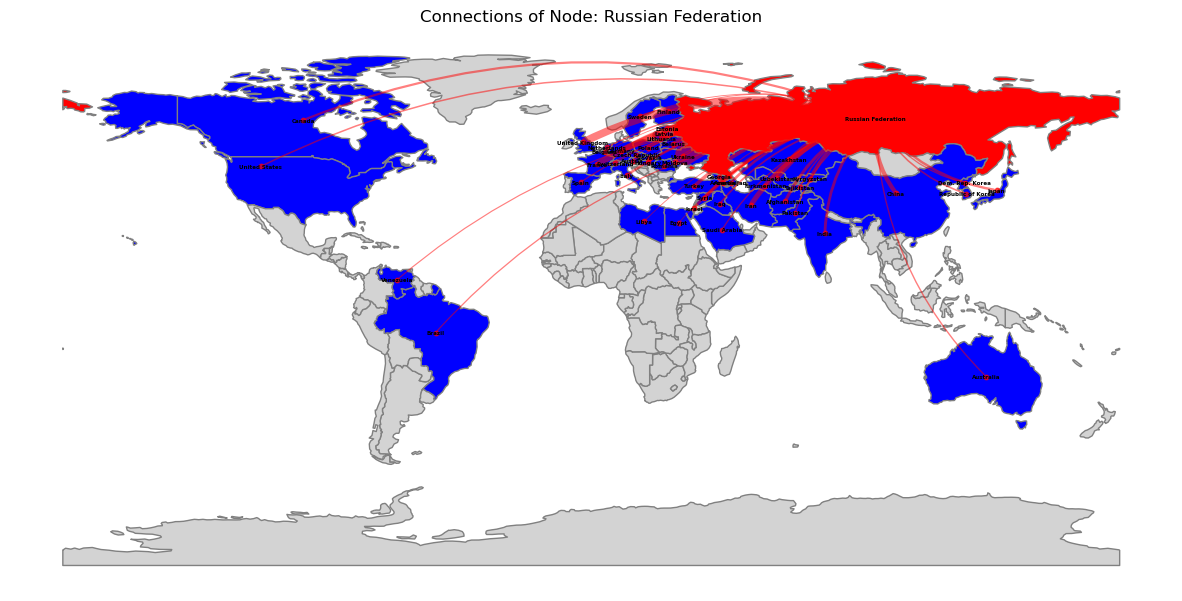

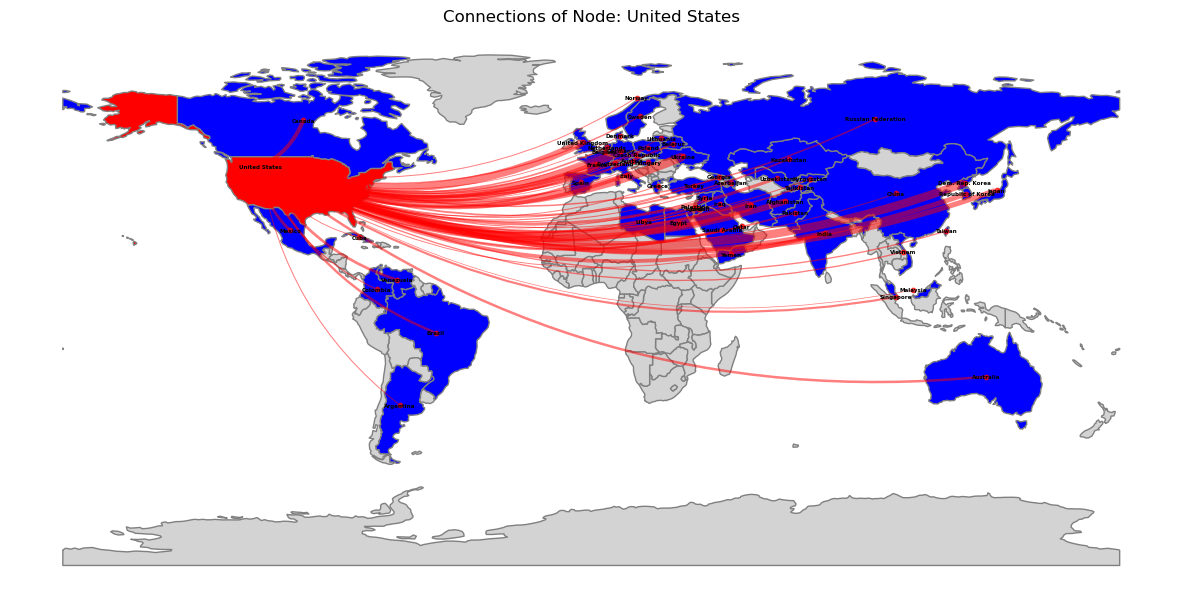

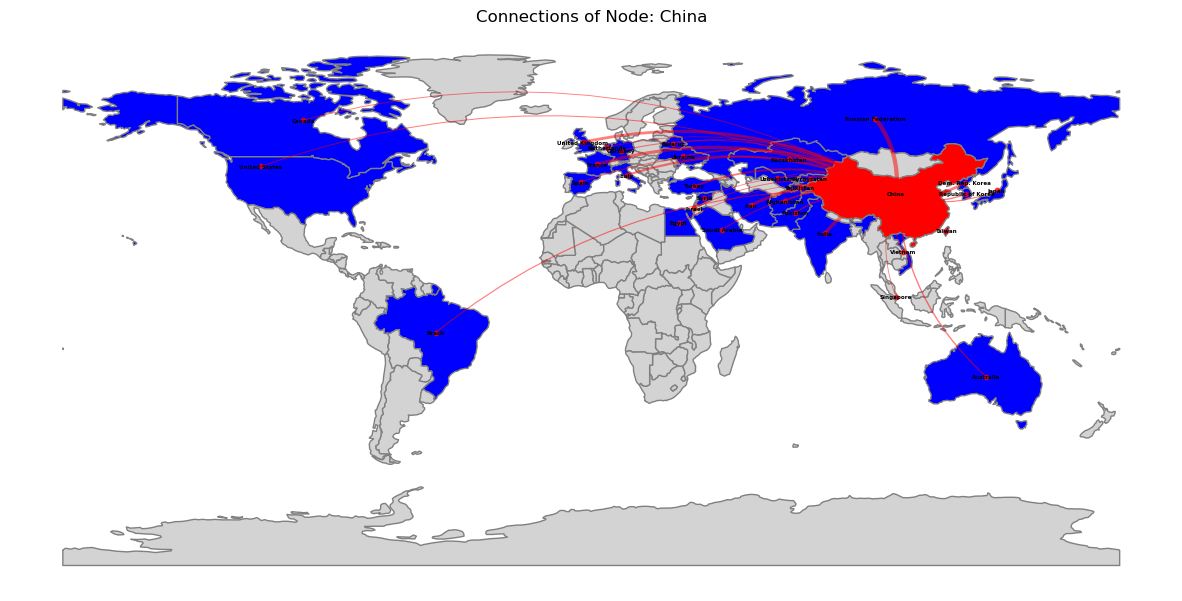

In [77]:
map = world

def get_colors(node):
    if node == target_node:
        return 'red'  # Target country
    elif node in connected_countries:
        return 'blue'  # Connected countries
    return 'lightgrey'  # All other countries

for i in ["Russian Federation", "United States", "China"]:
    # Define target node and get connected countries
    target_node = i
    
    # Get edges connected to the target node
    filtered_edges = [
        edge for edge in G.edges(target_node)
    ]
    connected_countries = [n for _, n in filtered_edges]  # Nodes connected to the target node
    
    # Assign colors to countries on the map
    map['color'] = map['NAME_LONG'].apply(lambda x: get_colors(x))
    ax = map.plot(color=map['color'], edgecolor='grey', figsize=(15, 10))
    
    # Plot network connections on top of the map
    for edge in filtered_edges:
        src, dest = edge
        weight = G.edges[edge].get('weight', 1) * 5  # Get edge weight
        draw_curved_edge(ax, geo_pos, src, dest, color="red", weight=weight, curvature=0.2)
    nodes_to_plot = [target_node] + [n for _, n in filtered_edges]
    
    # Draw nodes on the map
    nx.draw_networkx_nodes(
        G.subgraph(nodes_to_plot),
        geo_pos,
        node_size=10,
        node_color="red",
        alpha=0.7,
        ax=ax
    )
    
    # Add labels to the nodes
    nx.draw_networkx_labels(
        G.subgraph(nodes_to_plot),
        geo_pos,
        labels={node: node for node in nodes_to_plot},
        font_size=4,
        font_weight='bold',
        ax=ax
    )
    
    # Finalize the plot
    plt.title(f"Connections of Node: {target_node}")
    plt.axis("off")
    plt.show()


## Simulation

### Multiple Node Attack

In [80]:
# Parse the countries column into pairs (edges)
edges = []
for countries in data['countries']:
    country_list = countries[1:-1].split(', ')  # Remove square brackets and split
    if ("'Russian Federation'" not in country_list) and ("'China'" not in country_list) and ("'United States'" not in country_list):
        edges.extend([(str(country_list[i])[1:-1], str(country_list[j])[1:-1]) for i in range(len(country_list)) for j in range(i + 1, len(country_list))])

# Count edge occurrences to set weights
edge_counts = Counter(edges)

filtered_edges = [(country1, country2, weight) for (country1, country2), weight in edge_counts.items() if weight > 100] # if weight > 100


In [81]:
# Create the graph and add filtered edges
G = nx.Graph()
G.add_weighted_edges_from(filtered_edges)

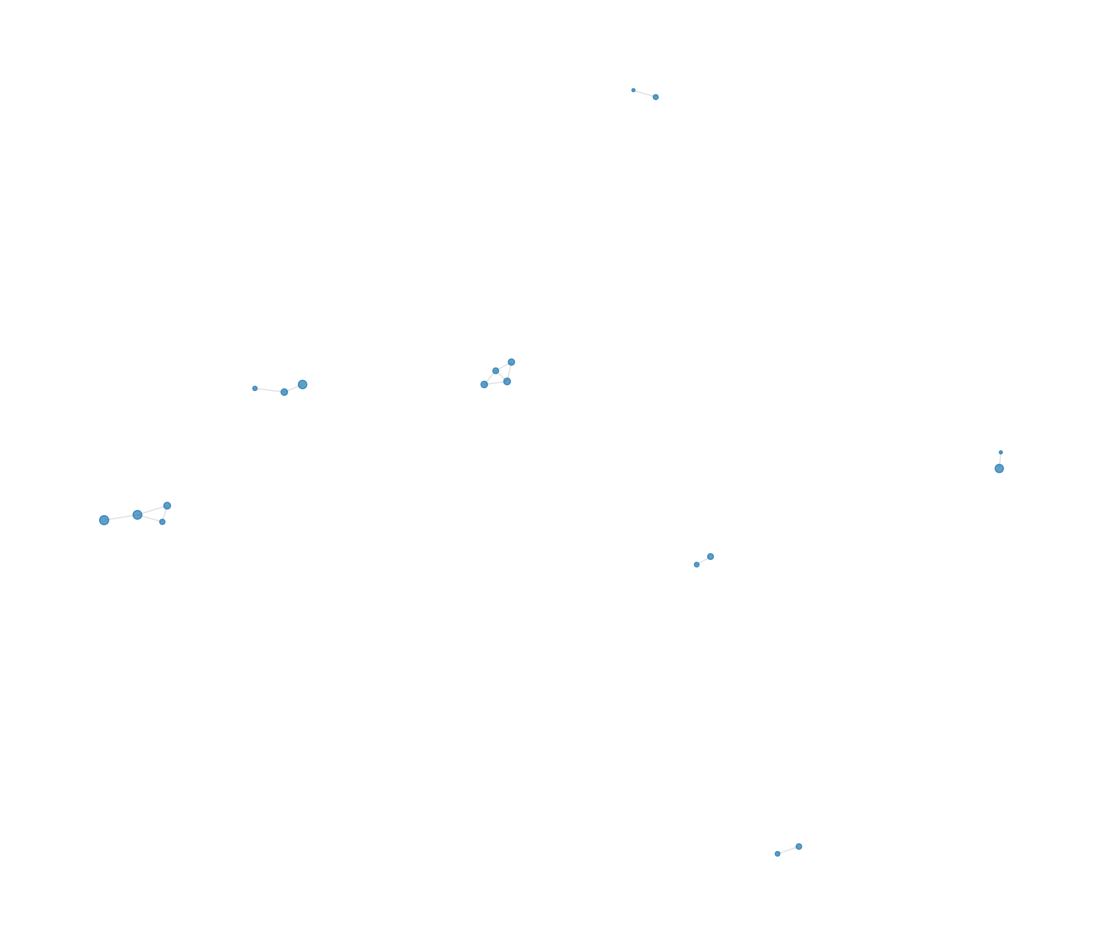

In [82]:
# Prepare plot
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)  # , seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1)


# plt.title("Advanced Network Visualization of Top 50 Country Network with Community Detection and Centrality")
plt.axis("off")
plt.show()

In [83]:
partition = community_louvain.best_partition(G, weight='weight')

# Map community numbers to colors
community_colors = [partition[node] for node in G.nodes]
unique_communities = set(community_colors)
community_color_map = {comm: plt.cm.tab20(i / len(unique_communities)) for i, comm in enumerate(unique_communities)}


# Experiment with different values of resolution
partition = community_louvain.best_partition(G, weight='weight')

# Count the number of communities detected
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

# Map community numbers to colors
community_colors = [partition[node] for node in G.nodes]
unique_communities = set(community_colors)
community_color_map = {comm: plt.cm.tab20(i / len(unique_communities)) for i, comm in enumerate(unique_communities)}

Number of communities detected: 7


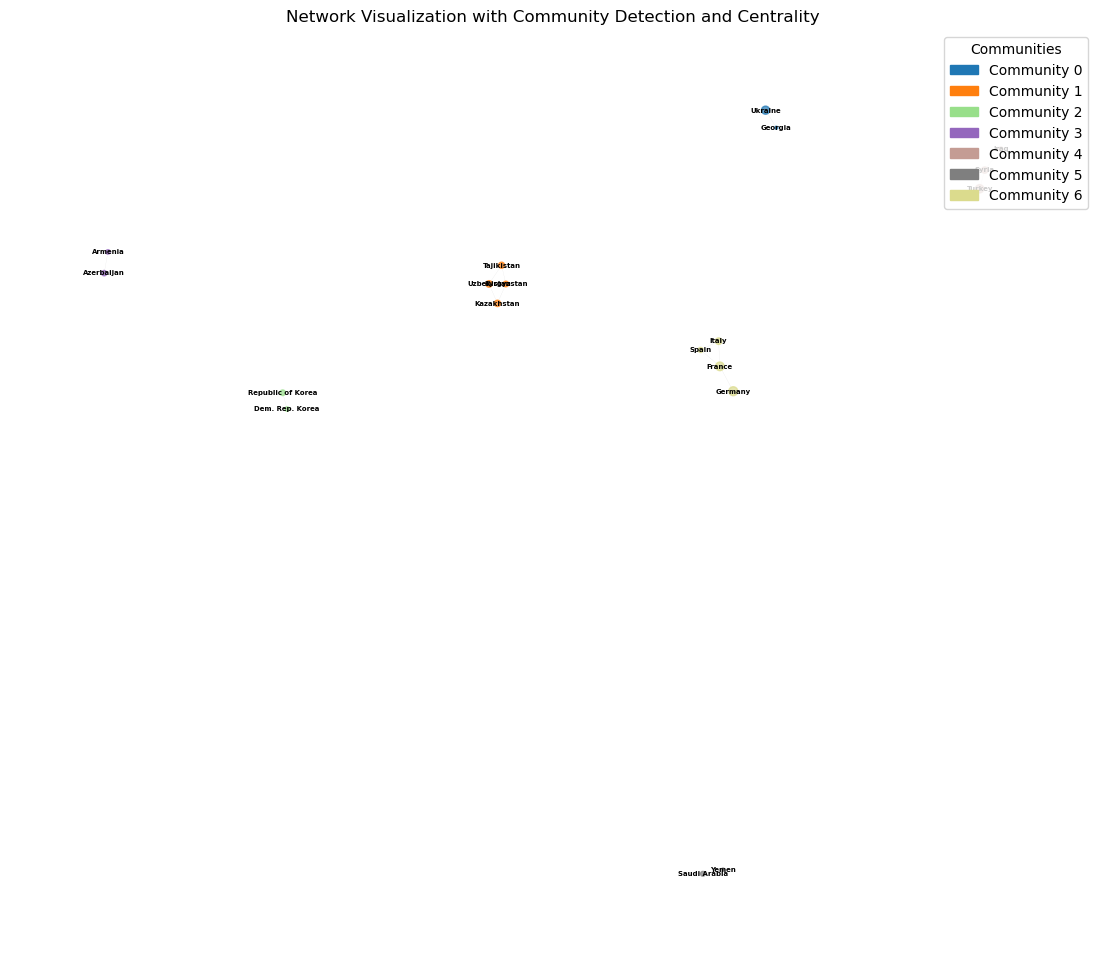

In [84]:
# Prepare plot
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)  # , seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=[community_color_map[partition[node]] for node in G.nodes],
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.2)

# Ensure we're only labeling nodes that exist in G
top_central_nodes = [node for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True) if node in G]
nx.draw_networkx_labels(
    G, pos,
    labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold'
)

# Add a legend for communities
community_patches = [
    mpatches.Patch(color=community_color_map[comm], label=f'Community {comm}')
    for comm in unique_communities
]
plt.legend(handles=community_patches, title="Communities", loc='upper right')

plt.title("Network Visualization with Community Detection and Centrality")
plt.axis("off")
plt.show()


/var/folders/vb/thqcpq9125j2b5v_172vv4k00000gn/T/ipykernel_34443/2201566457.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world["centroid"] = world.geometry.centroid


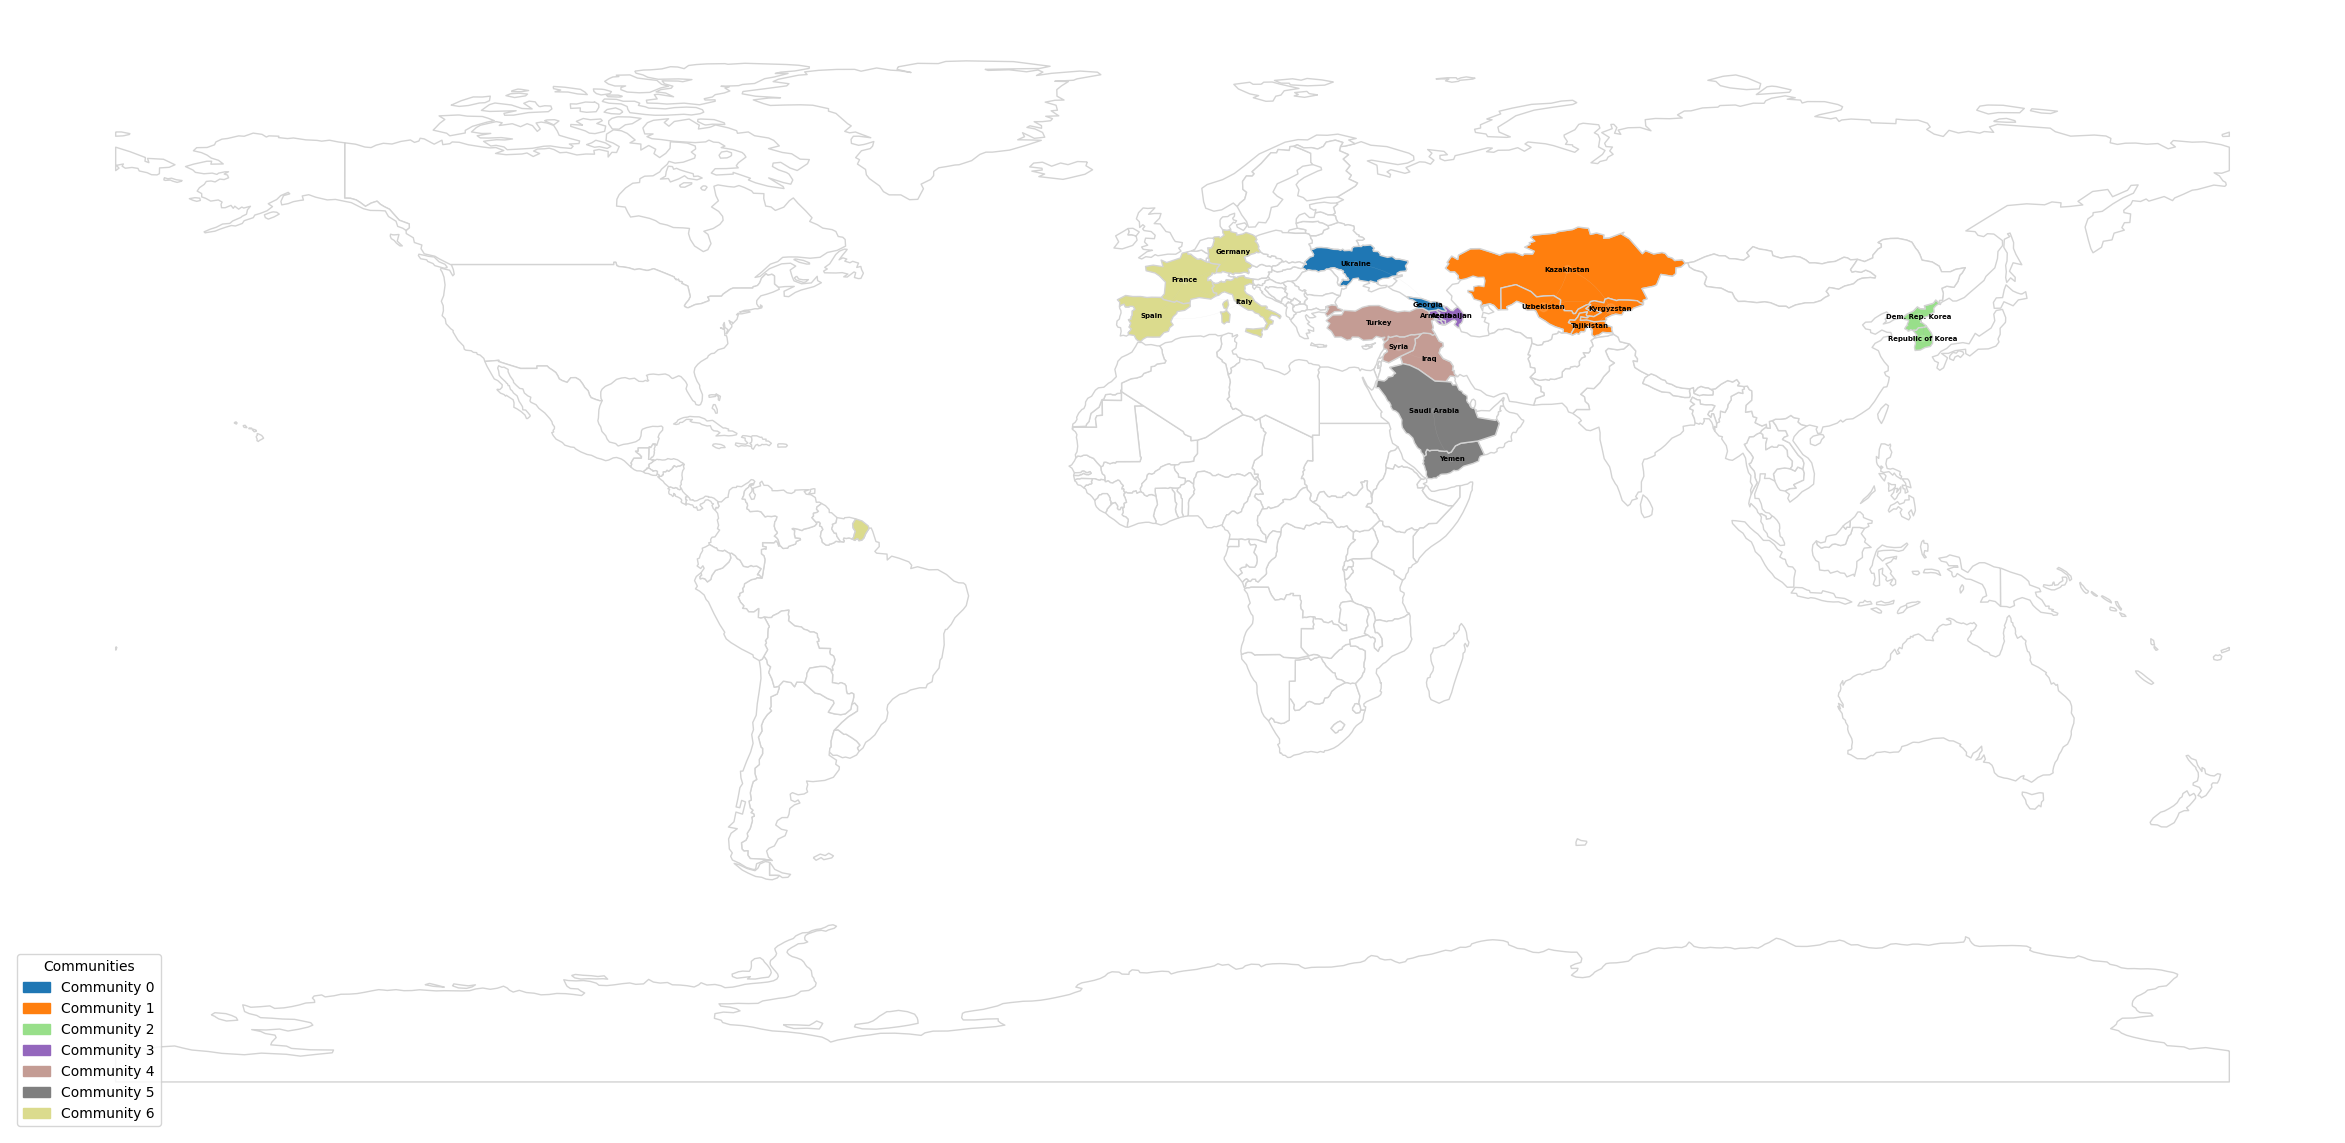

In [85]:
# Adjust the weight ranges for both edges and node sizes
weight_ranges = [
    (0, 100, 5, '#D3D3D3'),  # Light grey
    (101, 200, 10, '#D3D3D3'),  # Light grey
    (201, 300, 20, '#A9A9A9'),  # Dark grey
    (301, 400, 30, '#696969'),  # Dim grey
    (401, 500, 40, '#505050'),  # Medium grey
    (501, float('inf'), 50, '#000000')  # Black
]

# Background map
world = gpd.read_file('/Users/mellome/Desktop/ICSS-FP/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
# ax = world.plot(color='white', edgecolor='grey', figsize=(14, 12))
world['color'] = world['NAME_LONG'].apply(lambda x: get_color(x))
ax = world.plot(color=world['color'], edgecolor='lightgrey', figsize=(30, 20))

world["centroid"] = world.geometry.centroid
geo_pos = {
    row["NAME_LONG"]: (row["centroid"].x, row["centroid"].y)
    for _, row in world.iterrows()
}
# Correct geographic coordinates for France
if "France" in geo_pos:
    geo_pos["France"] = (2.0844, 46.3964)
if "Singapore" not in geo_pos:
    geo_pos["Singapore"] = (103.8198, 1.3521)  # Approximate coordinates for Singapore

# Prepare data for node sizes and edge colors
node_sizes = {}
edge_colors = {}
for node in G.nodes:
    total_weight = sum(edge_data['weight'] for _, _, edge_data in G.edges(node, data=True))
    node_sizes[node], _ = get_node_size_and_edge_color(total_weight)

for edge in G.edges(data=True):
    weight = edge[2].get('weight', 1)  # Default weight is 1 if missing
    _, edge_color = get_node_size_and_edge_color(weight)
    edge_colors[(edge[0], edge[1])] = edge_color

# Draw curved edges
for edge, color in edge_colors.items():
    src, dest = edge
    weight = G.edges[edge].get('weight', 1)
    draw_curved_edge(ax, geo_pos, src, dest, color=color, weight=weight, curvature=0.2)  # Adjust curvature as needed

# Draw nodes
nx.draw_networkx_nodes(
    G, geo_pos,
    node_size=[node_sizes[node] for node in G.nodes],
    node_color="white", #[community_color_map[partition[node]] for node in G.nodes]
    alpha=0.1,
    ax=ax
)

# Draw labels for top nodes
nx.draw_networkx_labels(
    G, geo_pos,
    labels={node: node for node in top_central_nodes},
    # labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold',
    ax=ax
)

# Add a legend for communities
unique_communities = set(partition.values())
community_patches = [
    mpatches.Patch(color=community_color_map[comm], label=f'Community {comm}')
    for comm in unique_communities
]
plt.legend(handles=community_patches, title="Communities", loc='lower left')

# Finalize plot
# plt.title("Geographic Network Visualization with Curved Edges")
plt.axis("off")
plt.show()

### Singular Node Attack (United States)

In [87]:
# Parse the countries column into pairs (edges)
edges = []
for countries in data['countries']:
    country_list = countries[1:-1].split(', ')  # Remove square brackets and split
    if "'United States'" not in country_list:
        edges.extend([(str(country_list[i])[1:-1], str(country_list[j])[1:-1]) for i in range(len(country_list)) for j in range(i + 1, len(country_list))])

# Count edge occurrences to set weights
edge_counts = Counter(edges)

filtered_edges = [(country1, country2, weight) for (country1, country2), weight in edge_counts.items() if weight > 100] # if weight > 100


In [88]:
# Create the graph and add filtered edges
G = nx.Graph()
G.add_weighted_edges_from(filtered_edges)

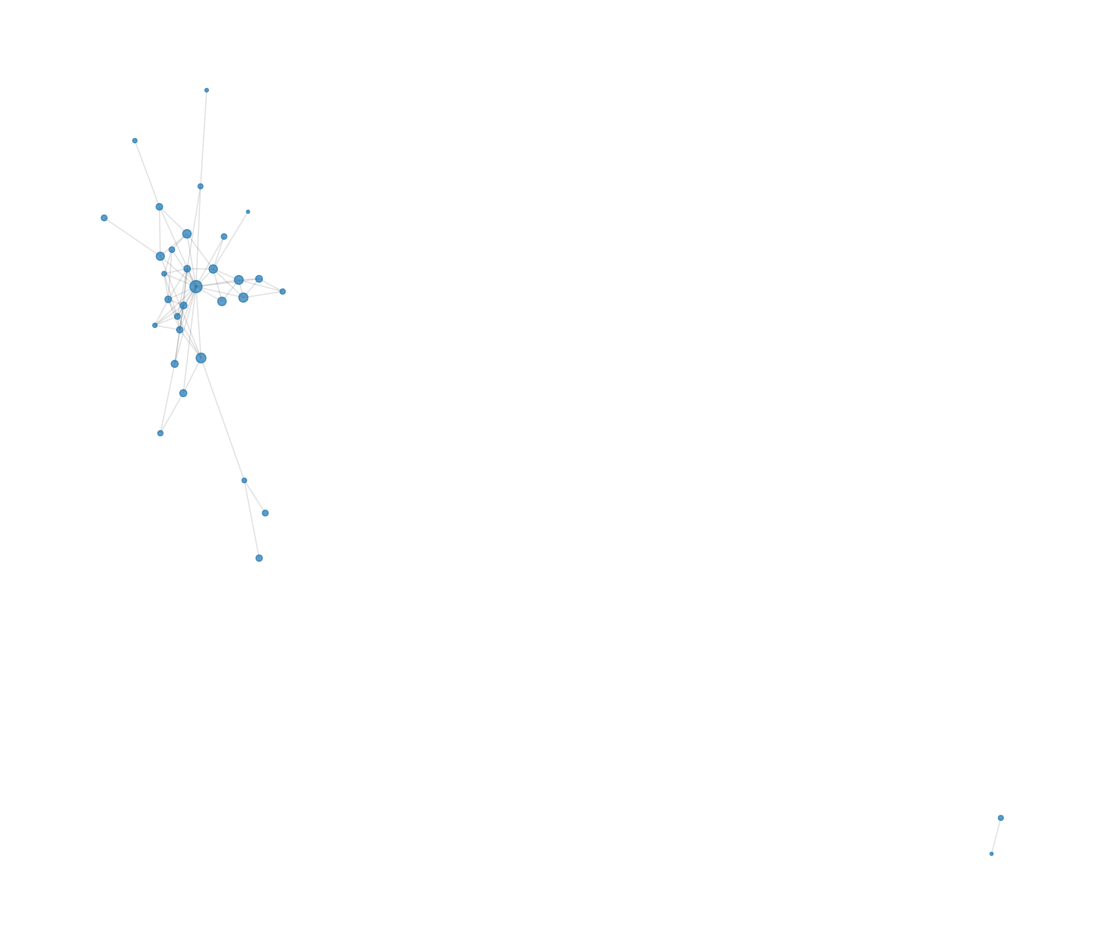

In [89]:
# Prepare plot
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)  # , seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1)


# plt.title("Advanced Network Visualization of Top 50 Country Network with Community Detection and Centrality")
plt.axis("off")
plt.show()

In [90]:
partition = community_louvain.best_partition(G, weight='weight')

# Map community numbers to colors
community_colors = [partition[node] for node in G.nodes]
unique_communities = set(community_colors)
community_color_map = {comm: plt.cm.tab20(i / len(unique_communities)) for i, comm in enumerate(unique_communities)}


# Experiment with different values of resolution
partition = community_louvain.best_partition(G, weight='weight')

# Count the number of communities detected
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

# Map community numbers to colors
community_colors = [partition[node] for node in G.nodes]
unique_communities = set(community_colors)
community_color_map = {comm: plt.cm.tab20(i / len(unique_communities)) for i, comm in enumerate(unique_communities)}

Number of communities detected: 6


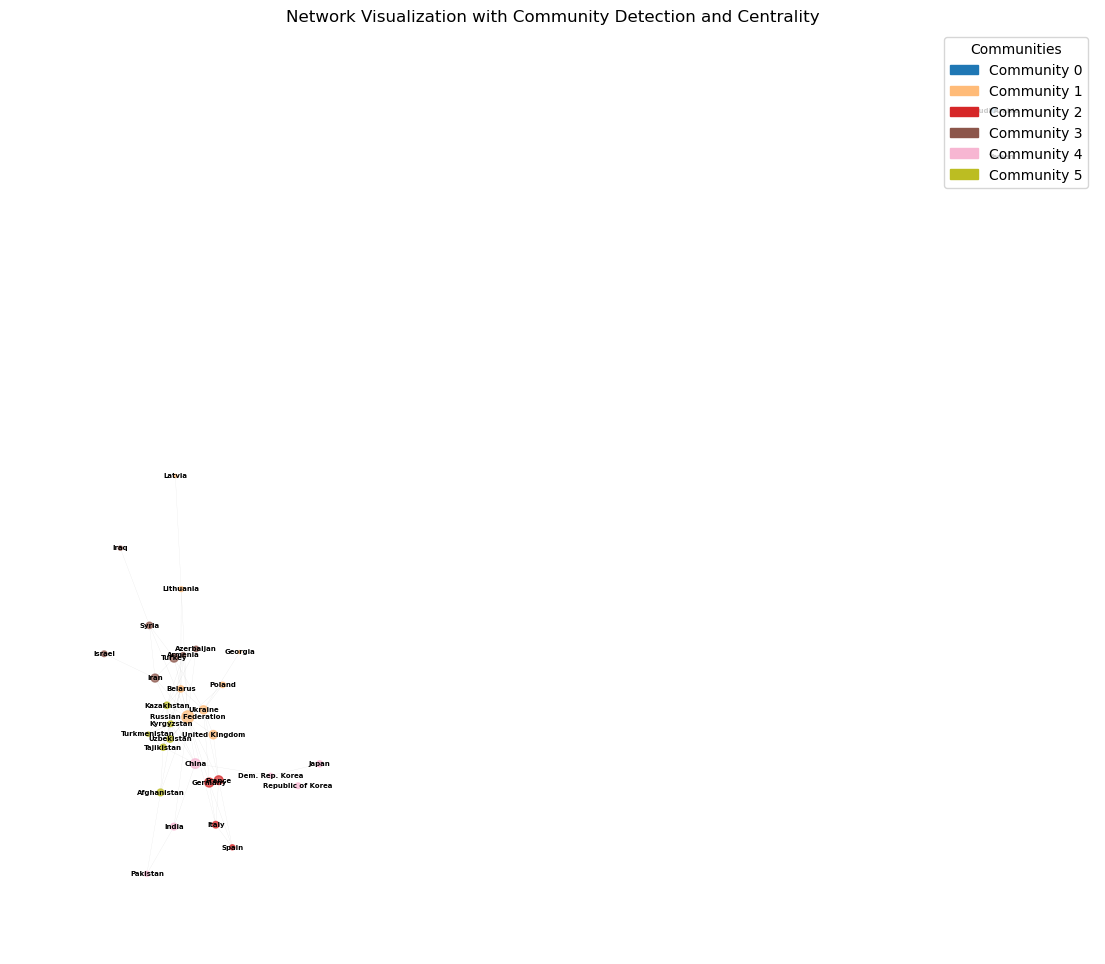

In [91]:
# Prepare plot
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)  # , seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=[community_color_map[partition[node]] for node in G.nodes],
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.2)

# Ensure we're only labeling nodes that exist in G
top_central_nodes = [node for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True) if node in G]
nx.draw_networkx_labels(
    G, pos,
    labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold'
)

# Add a legend for communities
community_patches = [
    mpatches.Patch(color=community_color_map[comm], label=f'Community {comm}')
    for comm in unique_communities
]
plt.legend(handles=community_patches, title="Communities", loc='upper right')

plt.title("Network Visualization with Community Detection and Centrality")
plt.axis("off")
plt.show()


/var/folders/vb/thqcpq9125j2b5v_172vv4k00000gn/T/ipykernel_34443/2201566457.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world["centroid"] = world.geometry.centroid


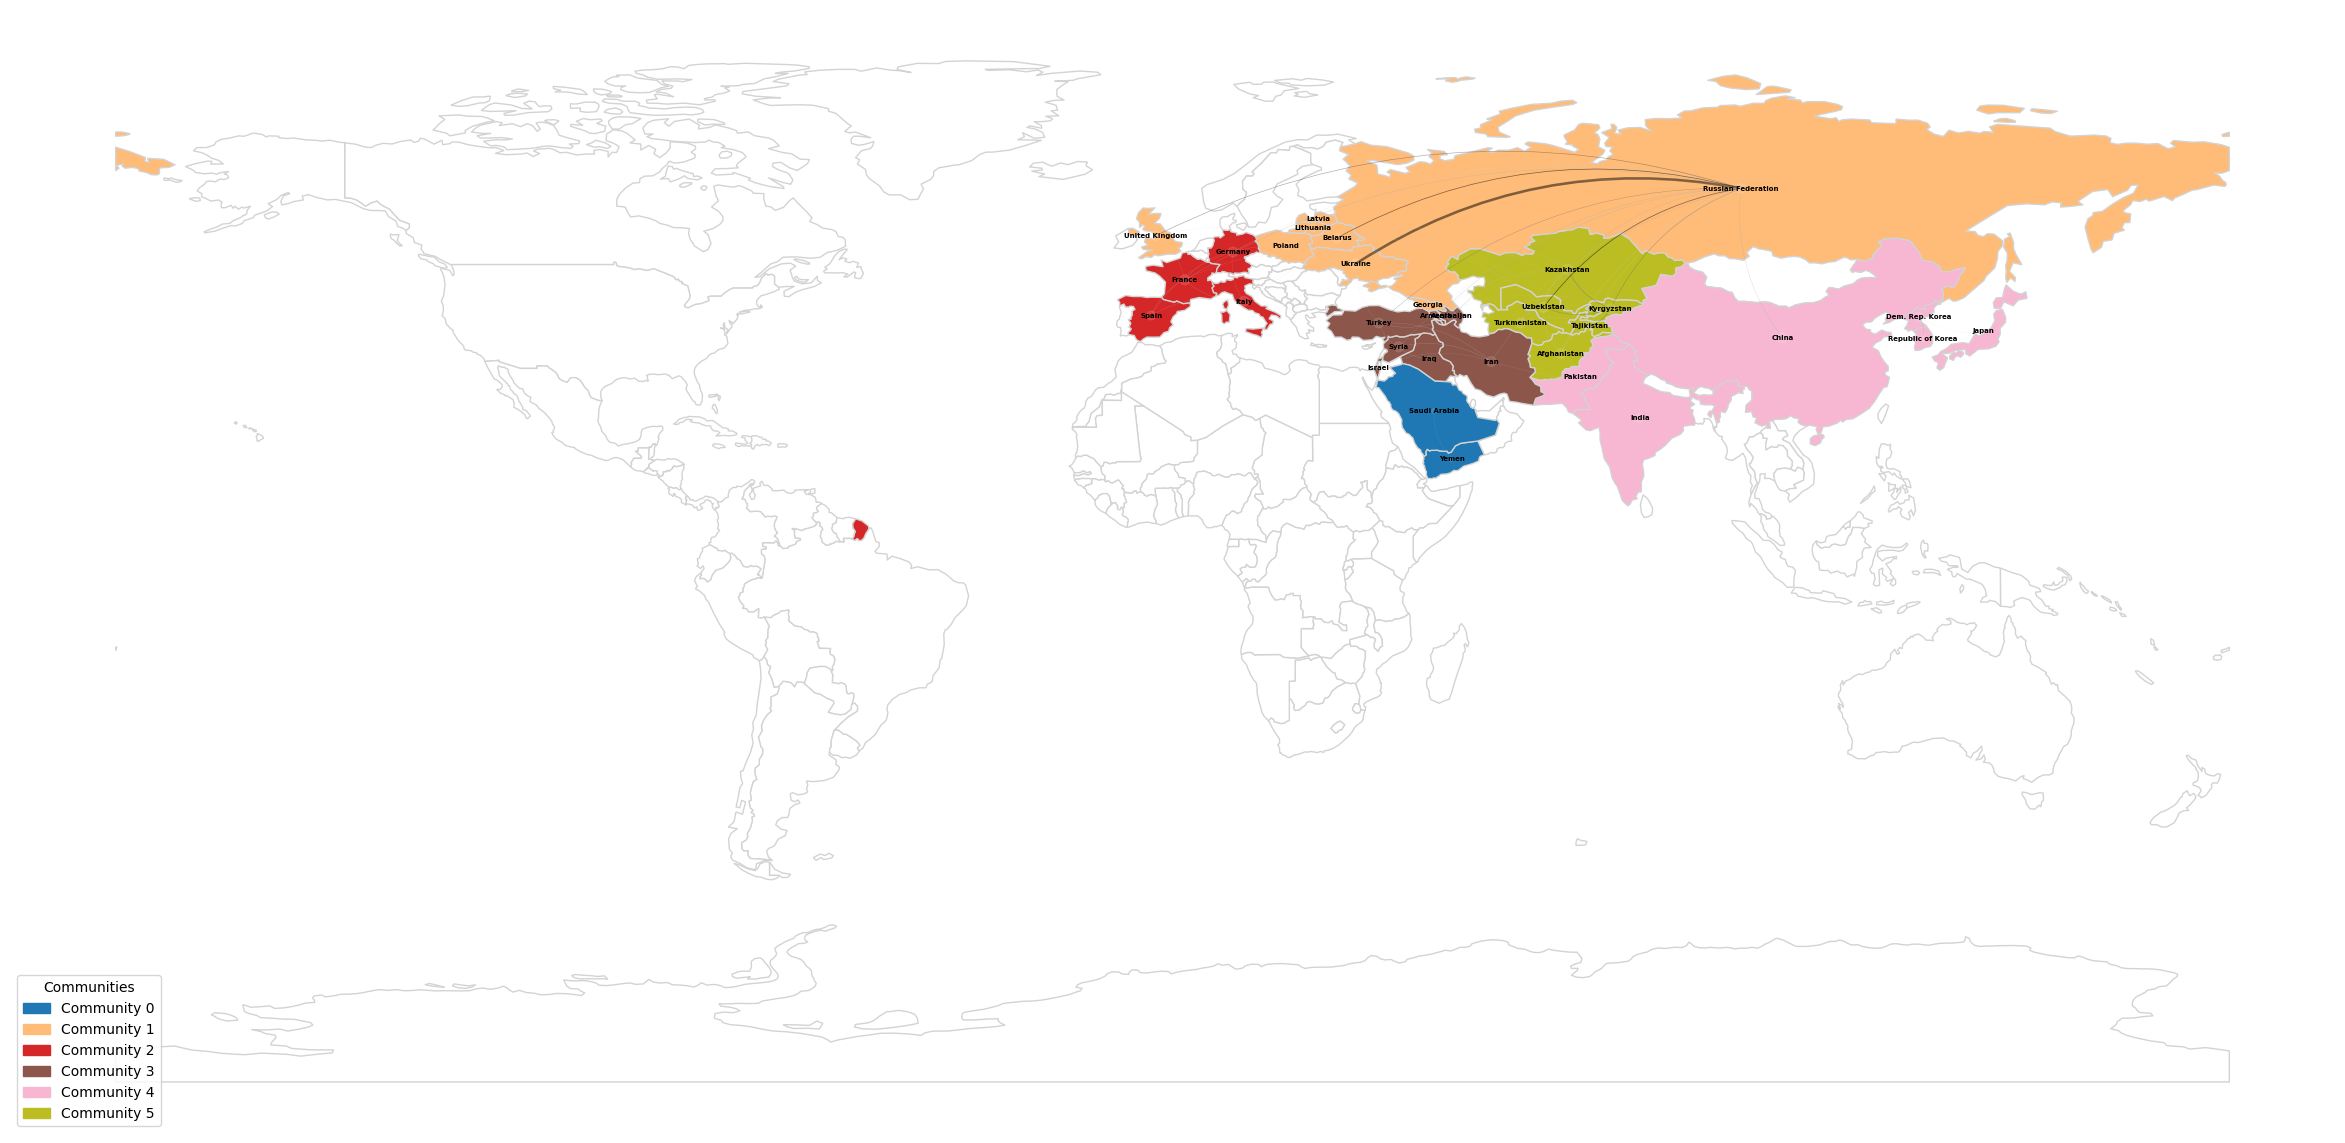

In [92]:
# Adjust the weight ranges for both edges and node sizes
weight_ranges = [
    (0, 100, 5, '#D3D3D3'),  # Light grey
    (101, 200, 10, '#D3D3D3'),  # Light grey
    (201, 300, 20, '#A9A9A9'),  # Dark grey
    (301, 400, 30, '#696969'),  # Dim grey
    (401, 500, 40, '#505050'),  # Medium grey
    (501, float('inf'), 50, '#000000')  # Black
]

# Background map
world = gpd.read_file('/Users/mellome/Desktop/ICSS-FP/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
# ax = world.plot(color='white', edgecolor='grey', figsize=(14, 12))
world['color'] = world['NAME_LONG'].apply(lambda x: get_color(x))
ax = world.plot(color=world['color'], edgecolor='lightgrey', figsize=(30, 20))

world["centroid"] = world.geometry.centroid
geo_pos = {
    row["NAME_LONG"]: (row["centroid"].x, row["centroid"].y)
    for _, row in world.iterrows()
}
# Correct geographic coordinates for France
if "France" in geo_pos:
    geo_pos["France"] = (2.0844, 46.3964)
if "Singapore" not in geo_pos:
    geo_pos["Singapore"] = (103.8198, 1.3521)  # Approximate coordinates for Singapore

# Prepare data for node sizes and edge colors
node_sizes = {}
edge_colors = {}
for node in G.nodes:
    total_weight = sum(edge_data['weight'] for _, _, edge_data in G.edges(node, data=True))
    node_sizes[node], _ = get_node_size_and_edge_color(total_weight)

for edge in G.edges(data=True):
    weight = edge[2].get('weight', 1)  # Default weight is 1 if missing
    _, edge_color = get_node_size_and_edge_color(weight)
    edge_colors[(edge[0], edge[1])] = edge_color

# Draw curved edges
for edge, color in edge_colors.items():
    src, dest = edge
    weight = G.edges[edge].get('weight', 1)
    draw_curved_edge(ax, geo_pos, src, dest, color=color, weight=weight, curvature=0.2)  # Adjust curvature as needed

# Draw nodes
nx.draw_networkx_nodes(
    G, geo_pos,
    node_size=[node_sizes[node] for node in G.nodes],
    node_color="white", #[community_color_map[partition[node]] for node in G.nodes]
    alpha=0.1,
    ax=ax
)

# Draw labels for top nodes
nx.draw_networkx_labels(
    G, geo_pos,
    labels={node: node for node in top_central_nodes},
    # labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold',
    ax=ax
)

# Add a legend for communities
unique_communities = set(partition.values())
community_patches = [
    mpatches.Patch(color=community_color_map[comm], label=f'Community {comm}')
    for comm in unique_communities
]
plt.legend(handles=community_patches, title="Communities", loc='lower left')

# Finalize plot
# plt.title("Geographic Network Visualization with Curved Edges")
plt.axis("off")
plt.show()

### Singular Node Attack (Russian Federation)

In [94]:
# Parse the countries column into pairs (edges)
edges = []
for countries in data['countries']:
    country_list = countries[1:-1].split(', ')  # Remove square brackets and split
    if "'Russian Federation'" not in country_list:
        edges.extend([(str(country_list[i])[1:-1], str(country_list[j])[1:-1]) for i in range(len(country_list)) for j in range(i + 1, len(country_list))])

# Count edge occurrences to set weights
edge_counts = Counter(edges)

filtered_edges = [(country1, country2, weight) for (country1, country2), weight in edge_counts.items() if weight > 100] # if weight > 100


In [95]:
# Create the graph and add filtered edges
G = nx.Graph()
G.add_weighted_edges_from(filtered_edges)

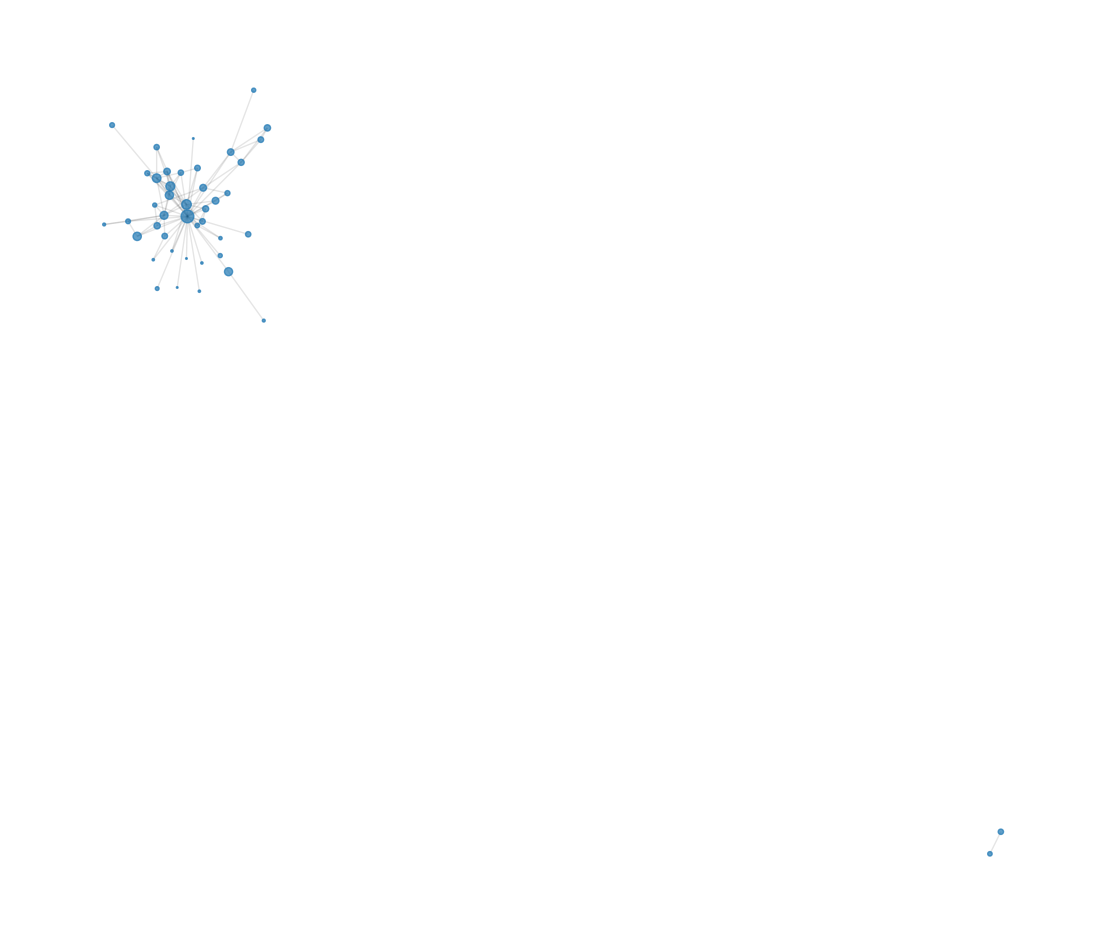

In [96]:
# Prepare plot
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)  # , seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1)


# plt.title("Advanced Network Visualization of Top 50 Country Network with Community Detection and Centrality")
plt.axis("off")
plt.show()

In [97]:
partition = community_louvain.best_partition(G, weight='weight')

# Map community numbers to colors
community_colors = [partition[node] for node in G.nodes]
unique_communities = set(community_colors)
community_color_map = {comm: plt.cm.tab20(i / len(unique_communities)) for i, comm in enumerate(unique_communities)}


# Experiment with different values of resolution
partition = community_louvain.best_partition(G, weight='weight')

# Count the number of communities detected
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

# Map community numbers to colors
community_colors = [partition[node] for node in G.nodes]
unique_communities = set(community_colors)
community_color_map = {comm: plt.cm.tab20(i / len(unique_communities)) for i, comm in enumerate(unique_communities)}

Number of communities detected: 7


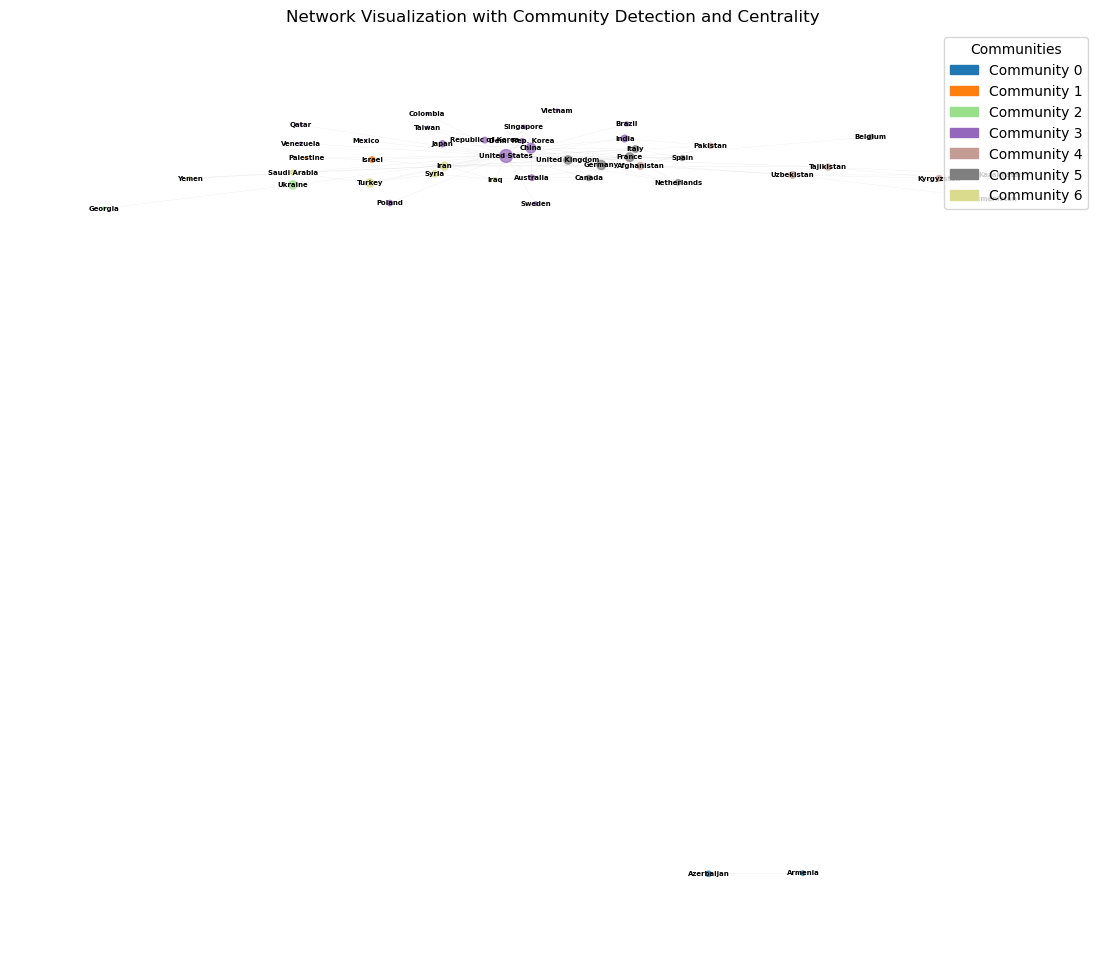

In [98]:
# Prepare plot
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)  # , seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=[community_color_map[partition[node]] for node in G.nodes],
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.2)

# Ensure we're only labeling nodes that exist in G
top_central_nodes = [node for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True) if node in G]
nx.draw_networkx_labels(
    G, pos,
    labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold'
)

# Add a legend for communities
community_patches = [
    mpatches.Patch(color=community_color_map[comm], label=f'Community {comm}')
    for comm in unique_communities
]
plt.legend(handles=community_patches, title="Communities", loc='upper right')

plt.title("Network Visualization with Community Detection and Centrality")
plt.axis("off")
plt.show()


/var/folders/vb/thqcpq9125j2b5v_172vv4k00000gn/T/ipykernel_34443/2201566457.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world["centroid"] = world.geometry.centroid


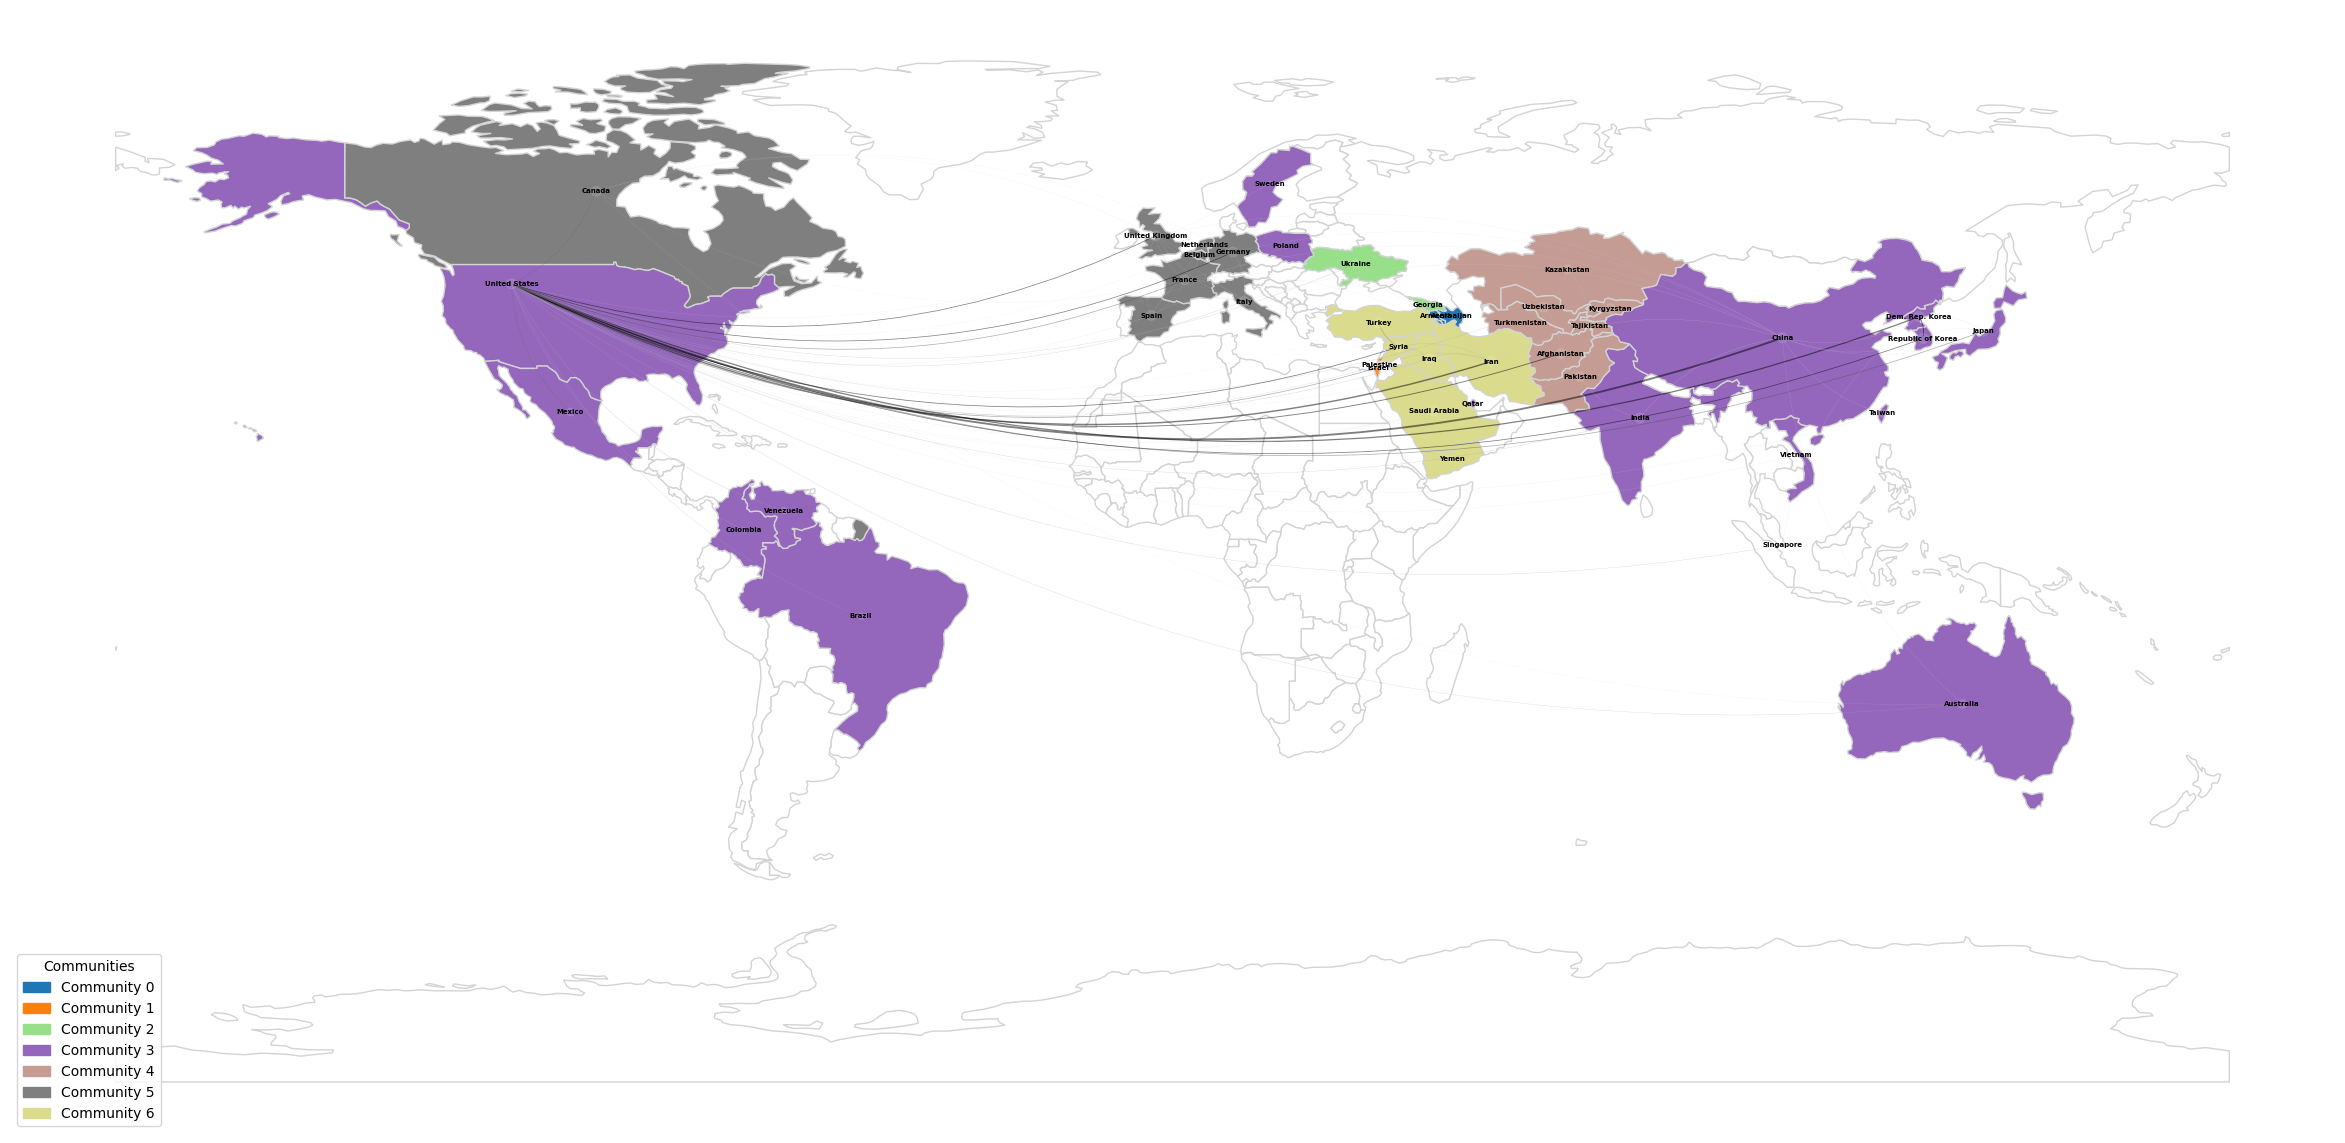

In [99]:
# Adjust the weight ranges for both edges and node sizes
weight_ranges = [
    (0, 100, 5, '#D3D3D3'),  # Light grey
    (101, 200, 10, '#D3D3D3'),  # Light grey
    (201, 300, 20, '#A9A9A9'),  # Dark grey
    (301, 400, 30, '#696969'),  # Dim grey
    (401, 500, 40, '#505050'),  # Medium grey
    (501, float('inf'), 50, '#000000')  # Black
]

# Background map
world = gpd.read_file('/Users/mellome/Desktop/ICSS-FP/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
# ax = world.plot(color='white', edgecolor='grey', figsize=(14, 12))
world['color'] = world['NAME_LONG'].apply(lambda x: get_color(x))
ax = world.plot(color=world['color'], edgecolor='lightgrey', figsize=(30, 20))

world["centroid"] = world.geometry.centroid
geo_pos = {
    row["NAME_LONG"]: (row["centroid"].x, row["centroid"].y)
    for _, row in world.iterrows()
}
# Correct geographic coordinates for France
if "France" in geo_pos:
    geo_pos["France"] = (2.0844, 46.3964)
if "Singapore" not in geo_pos:
    geo_pos["Singapore"] = (103.8198, 1.3521)  # Approximate coordinates for Singapore

# Prepare data for node sizes and edge colors
node_sizes = {}
edge_colors = {}
for node in G.nodes:
    total_weight = sum(edge_data['weight'] for _, _, edge_data in G.edges(node, data=True))
    node_sizes[node], _ = get_node_size_and_edge_color(total_weight)

for edge in G.edges(data=True):
    weight = edge[2].get('weight', 1)  # Default weight is 1 if missing
    _, edge_color = get_node_size_and_edge_color(weight)
    edge_colors[(edge[0], edge[1])] = edge_color

# Draw curved edges
for edge, color in edge_colors.items():
    src, dest = edge
    weight = G.edges[edge].get('weight', 1)
    draw_curved_edge(ax, geo_pos, src, dest, color=color, weight=weight, curvature=0.2)  # Adjust curvature as needed

# Draw nodes
nx.draw_networkx_nodes(
    G, geo_pos,
    node_size=[node_sizes[node] for node in G.nodes],
    node_color="white", #[community_color_map[partition[node]] for node in G.nodes]
    alpha=0.1,
    ax=ax
)

# Draw labels for top nodes
nx.draw_networkx_labels(
    G, geo_pos,
    labels={node: node for node in top_central_nodes},
    # labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold',
    ax=ax
)

# Add a legend for communities
unique_communities = set(partition.values())
community_patches = [
    mpatches.Patch(color=community_color_map[comm], label=f'Community {comm}')
    for comm in unique_communities
]
plt.legend(handles=community_patches, title="Communities", loc='lower left')

# Finalize plot
# plt.title("Geographic Network Visualization with Curved Edges")
plt.axis("off")
plt.show()

### Singular Node Attack (China)

In [101]:
# Parse the countries column into pairs (edges)
edges = []
for countries in data['countries']:
    country_list = countries[1:-1].split(', ')  # Remove square brackets and split
    if "'China'" not in country_list:
        edges.extend([(str(country_list[i])[1:-1], str(country_list[j])[1:-1]) for i in range(len(country_list)) for j in range(i + 1, len(country_list))])

# Count edge occurrences to set weights
edge_counts = Counter(edges)

filtered_edges = [(country1, country2, weight) for (country1, country2), weight in edge_counts.items() if weight > 100] # if weight > 100


In [102]:
# Create the graph and add filtered edges
G = nx.Graph()
G.add_weighted_edges_from(filtered_edges)

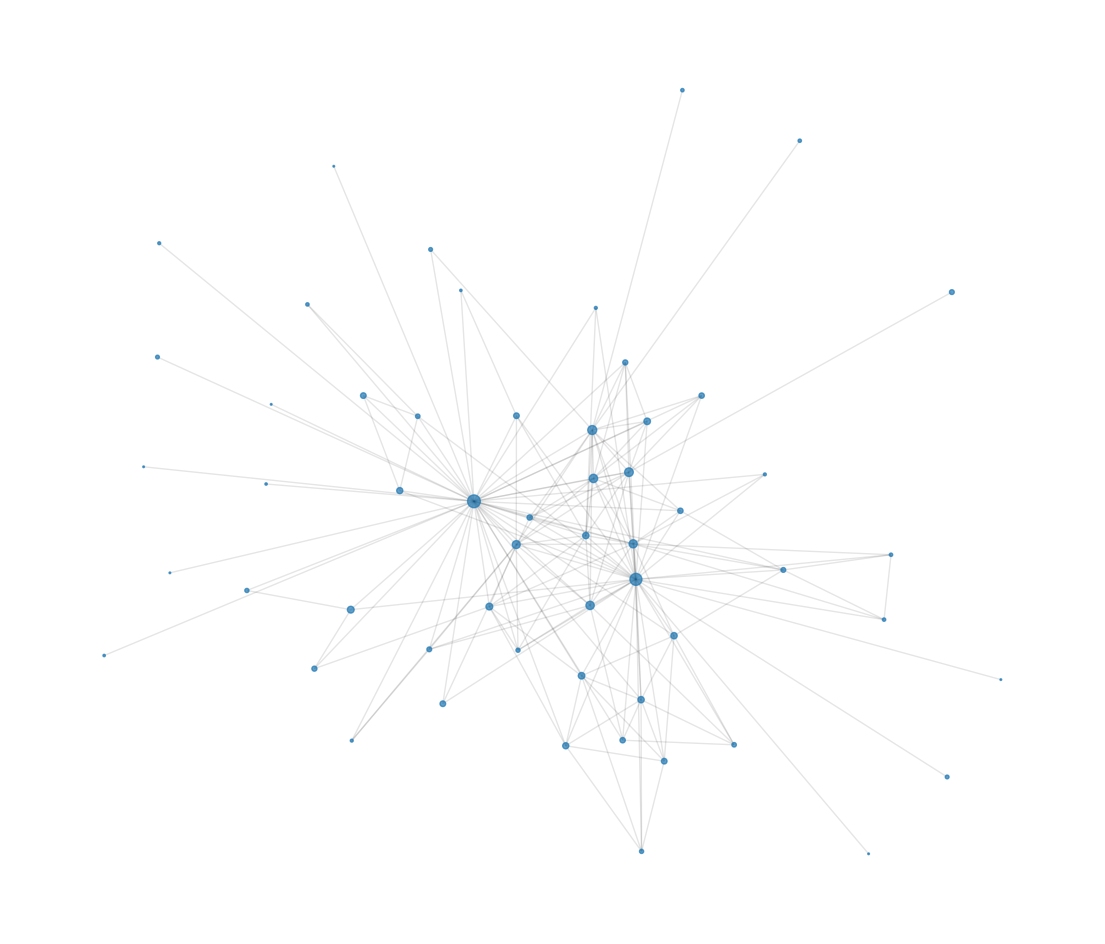

In [103]:
# Prepare plot
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)  # , seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1)


# plt.title("Advanced Network Visualization of Top 50 Country Network with Community Detection and Centrality")
plt.axis("off")
plt.show()

In [104]:
partition = community_louvain.best_partition(G, weight='weight')

# Map community numbers to colors
community_colors = [partition[node] for node in G.nodes]
unique_communities = set(community_colors)
community_color_map = {comm: plt.cm.tab20(i / len(unique_communities)) for i, comm in enumerate(unique_communities)}


# Experiment with different values of resolution
partition = community_louvain.best_partition(G, weight='weight')

# Count the number of communities detected
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

# Map community numbers to colors
community_colors = [partition[node] for node in G.nodes]
unique_communities = set(community_colors)
community_color_map = {comm: plt.cm.tab20(i / len(unique_communities)) for i, comm in enumerate(unique_communities)}

Number of communities detected: 5


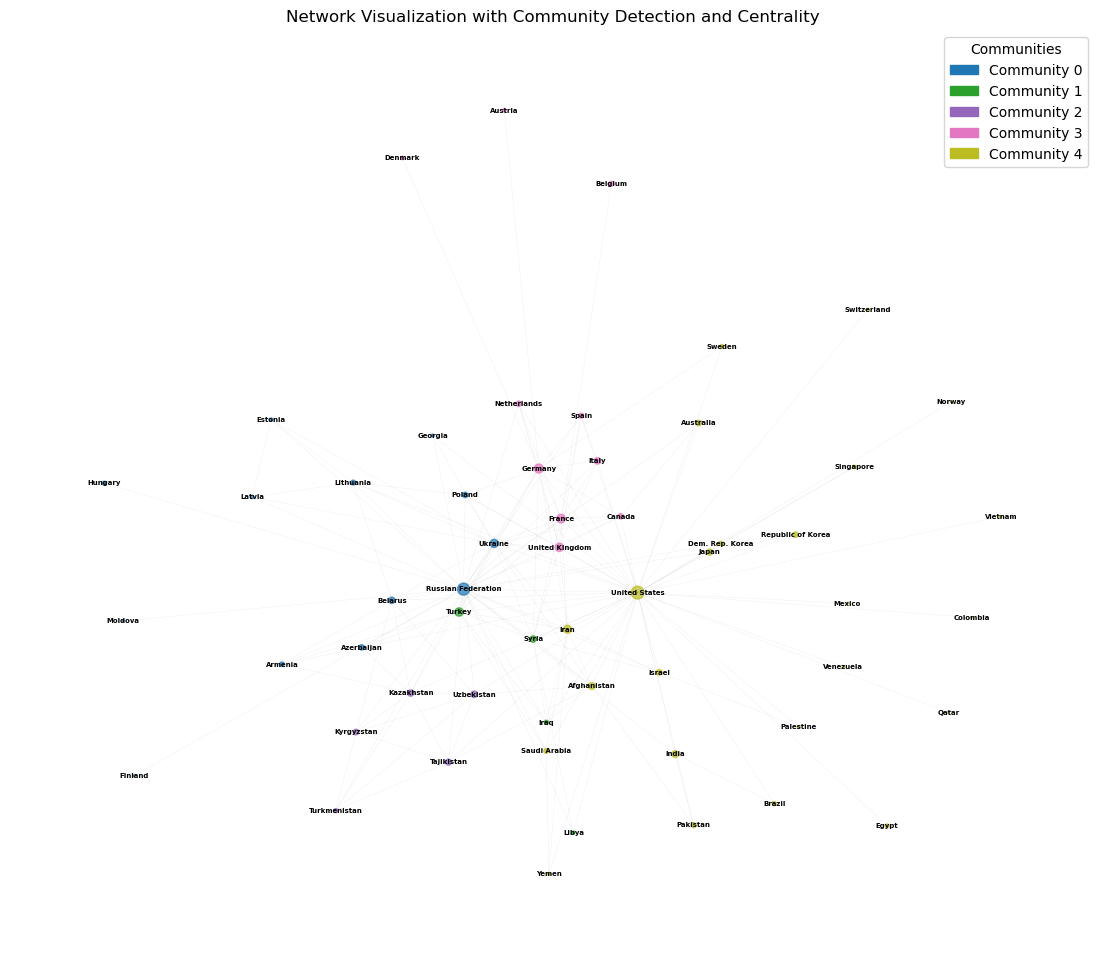

In [105]:
# Prepare plot
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)  # , seed=42

# Draw nodes with size based on degree centrality and transparency
node_sizes = [degree_centrality[node] * 100 for node in G.nodes]  # Scale node size for better visibility
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=[community_color_map[partition[node]] for node in G.nodes],
    alpha=0.7,  # Set transparency for nodes
)

# Draw edges with low opacity and thin lines to reduce visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.2)

# Ensure we're only labeling nodes that exist in G
top_central_nodes = [node for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True) if node in G]
nx.draw_networkx_labels(
    G, pos,
    labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold'
)

# Add a legend for communities
community_patches = [
    mpatches.Patch(color=community_color_map[comm], label=f'Community {comm}')
    for comm in unique_communities
]
plt.legend(handles=community_patches, title="Communities", loc='upper right')

plt.title("Network Visualization with Community Detection and Centrality")
plt.axis("off")
plt.show()


/var/folders/vb/thqcpq9125j2b5v_172vv4k00000gn/T/ipykernel_34443/2201566457.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world["centroid"] = world.geometry.centroid


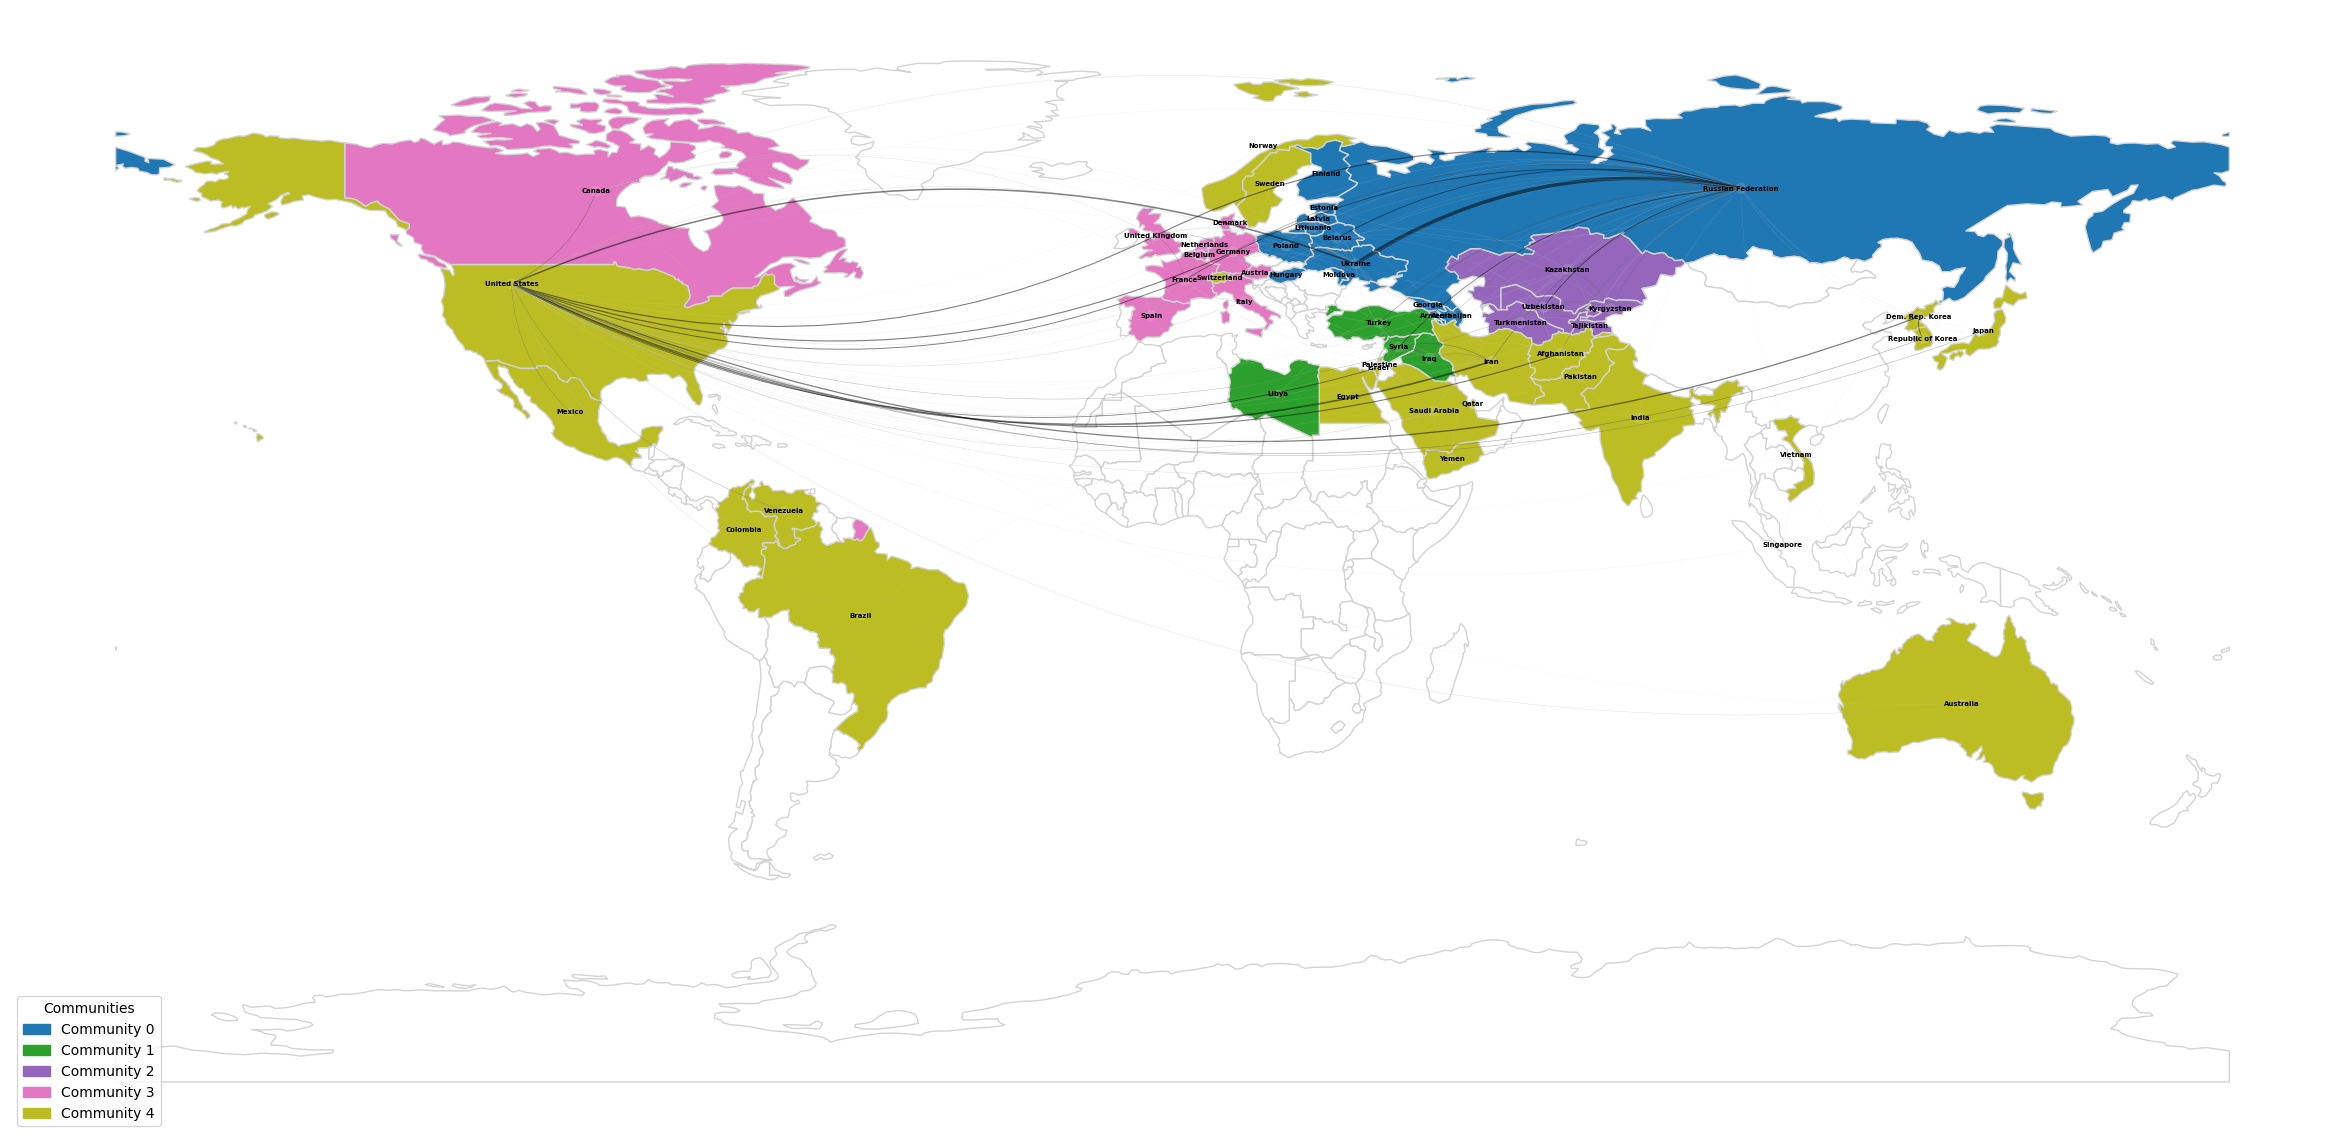

In [106]:
# Adjust the weight ranges for both edges and node sizes
weight_ranges = [
    (0, 100, 5, '#D3D3D3'),  # Light grey
    (101, 200, 10, '#D3D3D3'),  # Light grey
    (201, 300, 20, '#A9A9A9'),  # Dark grey
    (301, 400, 30, '#696969'),  # Dim grey
    (401, 500, 40, '#505050'),  # Medium grey
    (501, float('inf'), 50, '#000000')  # Black
]

# Background map
world = gpd.read_file('/Users/mellome/Desktop/ICSS-FP/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
# ax = world.plot(color='white', edgecolor='grey', figsize=(14, 12))
world['color'] = world['NAME_LONG'].apply(lambda x: get_color(x))
ax = world.plot(color=world['color'], edgecolor='lightgrey', figsize=(30, 20))

world["centroid"] = world.geometry.centroid
geo_pos = {
    row["NAME_LONG"]: (row["centroid"].x, row["centroid"].y)
    for _, row in world.iterrows()
}
# Correct geographic coordinates for France
if "France" in geo_pos:
    geo_pos["France"] = (2.0844, 46.3964)
if "Singapore" not in geo_pos:
    geo_pos["Singapore"] = (103.8198, 1.3521)  # Approximate coordinates for Singapore

# Prepare data for node sizes and edge colors
node_sizes = {}
edge_colors = {}
for node in G.nodes:
    total_weight = sum(edge_data['weight'] for _, _, edge_data in G.edges(node, data=True))
    node_sizes[node], _ = get_node_size_and_edge_color(total_weight)

for edge in G.edges(data=True):
    weight = edge[2].get('weight', 1)  # Default weight is 1 if missing
    _, edge_color = get_node_size_and_edge_color(weight)
    edge_colors[(edge[0], edge[1])] = edge_color

# Draw curved edges
for edge, color in edge_colors.items():
    src, dest = edge
    weight = G.edges[edge].get('weight', 1)
    draw_curved_edge(ax, geo_pos, src, dest, color=color, weight=weight, curvature=0.2)  # Adjust curvature as needed

# Draw nodes
nx.draw_networkx_nodes(
    G, geo_pos,
    node_size=[node_sizes[node] for node in G.nodes],
    node_color="white", #[community_color_map[partition[node]] for node in G.nodes]
    alpha=0.1,
    ax=ax
)

# Draw labels for top nodes
nx.draw_networkx_labels(
    G, geo_pos,
    labels={node: node for node in top_central_nodes},
    # labels={node: node for node in top_central_nodes},
    font_size=5, font_weight='bold',
    ax=ax
)

# Add a legend for communities
unique_communities = set(partition.values())
community_patches = [
    mpatches.Patch(color=community_color_map[comm], label=f'Community {comm}')
    for comm in unique_communities
]
plt.legend(handles=community_patches, title="Communities", loc='lower left')

# Finalize plot
# plt.title("Geographic Network Visualization with Curved Edges")
plt.axis("off")
plt.show()